# CUDA HRP (60-Month Lookback)

## Two-Stage Hierarchical Risk Parity Portfolio Optimization

### Statistical Validity: N < T
Instead of feeding 500-600 individual stocks into HRP (N >> T = 60, causing rank-deficient covariance), we use a **two-stage approach**:

1. **Stage 1 (Within-Industry)**: Aggregate stocks into 12 **Value-Weighted Fama-French Industry ETFs**
2. **Stage 2 (Across-Industry)**: Apply **HRP** to the 12 industry ETFs (N=12 < T=60, **full-rank covariance**)

### Key Features
- **Statistically Valid**: Covariance matrix is 12×12 with 60 observations (full rank, no shrinkage needed)
- GPU-accelerated via CUDA/CuPy
- Monthly rebalancing with liquidity-filtered universe
- Final stock weights = `industry_weight × within_industry_weight`

In [1]:
# Cell 0: Install Required Packages (Run if not already installed)

# Note: ta (not ta-lib) is easier to install on Windows
# Using cupy-cuda12x for CUDA 12.x compatibility (RTX 5090 with CUDA 12.8)
# PyTorch 2.8 template compatibility
!pip install cupy-cuda12x scikit-learn scipy tqdm pandas numpy matplotlib xgboost ta joblib pyyaml pytest optuna

In [2]:
# Dependencies

import os
import sys
import importlib
import pandas as pd

# Add utils/ to path
current_dir = os.getcwd()
utils_path = os.path.join(os.path.dirname(current_dir), 'utils')
if utils_path not in sys.path:
    sys.path.insert(0, utils_path)

import hrp_setup
import hrp_data
import hrp_analytics
import hrp_logger 

# Setup Environment (Imports, Cache, GPU, Seeds)
project_root, GPU_AVAILABLE, hrp_pipeline = hrp_setup.setup_environment(current_dir)

# Load Configuration
config = hrp_setup.load_config(project_root)

# Setup Logging
log_file_path = os.path.join(project_root, 'hrp_agent.log')
logger = hrp_logger.setup_logger(log_file=log_file_path)
logger.info("Starting HRP Pipeline (60-Month Window)")

# Configuration from Config File
if config:
    super_agent_dir = os.path.join(project_root, config['project']['output_dir'])
    window = config['data']['window']
    rebalance_freq = config['data']['rebalance_freq']
    min_stocks = config['data']['min_stocks']
    market_index = config['data']['market_index']
    logger.info(f"Loaded configuration: Window={window}, Rebalance={rebalance_freq}")
else:
    # Fallback if config fails
    logger.warning("Config load failed, using defaults")
    super_agent_dir = os.path.join(project_root, 'Super_Agent_Output')
    window = 60
    rebalance_freq = '1M'
    min_stocks = 20
    market_index = 'VWRETD'

os.makedirs(super_agent_dir, exist_ok=True)
logger.info(f"Output Directory: {super_agent_dir}")

✓ Cleared module cache
✓ CuPy version: 13.6.0
✓ CUDA version: 12090
✓ Random seeds set to 42
✓ Loaded configuration from /workspace/HRP/config.yaml
✓ Random seeds set to 42
2026-01-07 21:35:38,824 - HRP_Agent - INFO - Starting HRP Pipeline (60-Month Window)
2026-01-07 21:35:38,826 - HRP_Agent - INFO - Loaded configuration: Window=60, Rebalance=1M
2026-01-07 21:35:38,827 - HRP_Agent - INFO - Output Directory: /workspace/HRP/Super_Agent_Output


In [3]:
# Step 1: Load and Filter Data

# Locate Files
data_path, benchmark_path, prep_path, comp_path = hrp_setup.get_file_paths(project_root, hrp_data)

# Load Market Data (now also returns df_universe for industry ETF computation)
returns_all, dates, valid_rebal_dates, df_ml_universe, universe_flags, df_universe = hrp_data.load_market_data(
    data_path, 
    benchmark_path,
    start_date_str='1960-01-01', 
    market_index=market_index, 
    windows=[window],  
    freq=rebalance_freq
)

# Load Risk Free Rate
rf_monthly_aligned = hrp_data.load_risk_free_rate(prep_path, dates, start_date_str='1960-01-01')

print(f"{'='*70}")
print(f"df_universe shape: {df_universe.shape} (for industry ETF construction)")
print(f"FF_12 column present: {'FF_12' in df_universe.columns}")
print(f"{'='*70}\n")

✓ Found data at: /workspace/HRP/DATA/CRSP/CRSP_selected_columns.csv
Loading stock data from /workspace/HRP/DATA/CRSP/CRSP_selected_columns.csv...
Loaded raw data: 5218898 rows, 10 columns
Unique PERMNOs (Raw): 38843
Filtering raw data to start from 1960-01-01...
Unique PERMNOs (After Date Filter): 38384
Filtering by SHRCD (10, 11) and EXCHCD (1, 2, 3)...
Unique PERMNOs (After SHRCD/EXCHCD Filter): 26293
Merging RET and DLRET columns...
Calculating universe flags...
✓ Found SIC mapping file: /workspace/HRP/DATA/CRSP/SIC_to_Fama_French_industry.csv
Mapping stocks to Fama-French 12 Industries...
Calculating Rolling 12-Month Median Liquidity...
Filtering Top 20% Liquidity per Industry/Date...
  - Applied FF12 Industry Filter (Top 20% Rolling Median Liquidity)
  - Market Cap: Top 80% (for ML Universe)
Unique PERMNOs (ML Universe - Top 80% Mkt Cap): 24160
Unique PERMNOs (HRP Universe - Liquidity & Price): 7088
Universe (Full): 3510365 rows
Universe (ML Features): 2774687 rows
[!] Found dupli

In [4]:
# Step 2: Two-Stage HRP Weights & Monthly Returns Computation
# Stage 1: Value-weighted Fama-French 12 Industry ETFs
# Stage 2: HRP allocation across 12 industries (N=12 < T=60, statistically valid)

import hrp_functions
import hrp_pipeline

# Check config for recompute option (defaults to True if not specified)
recompute_weights = config.get('computation', {}).get('recompute_weights', True)

# Minimum industries required for HRP (default 6 to ensure diversification)
min_industries = config.get('data', {}).get('min_industries', 6)

if recompute_weights:
    print("="*70)
    print("TWO-STAGE HRP: Industry ETF Approach")
    print("="*70)
    print("Stage 1: Aggregate stocks into 12 Value-Weighted FF Industry ETFs")
    print("Stage 2: Apply HRP to 12 industries (N=12 < T=60, FULL RANK)")
    print("="*70)
    print("▶ Recomputing HRP weights from scratch...")
    
    strategy_returns = hrp_pipeline.run_hrp_computation(
        returns_all, 
        valid_rebal_dates, 
        window, 
        min_industries,  # Now this is min industries, not min stocks
        super_agent_dir,
        universe_flags=universe_flags,
        df_universe=df_universe,       # Required for industry ETF construction
        use_industry_etfs=True,        # Enable two-stage industry ETF mode
        min_stocks_per_industry=3,     # Min stocks per industry
        use_gpu=GPU_AVAILABLE          # GPU acceleration if available (detected in cell 2)
    )
else:
    print("▶ Loading pre-computed HRP weights (recompute_weights: false)")
    # Load pre-computed CSV files
    weights_path = os.path.join(super_agent_dir, 'all_hrp_weights.csv')
    returns_path = os.path.join(super_agent_dir, 'hrp_strategy_returns.csv')
    industry_weights_path = os.path.join(super_agent_dir, 'hrp_industry_weights.csv')
    
    if not os.path.exists(weights_path) or not os.path.exists(returns_path):
        raise FileNotFoundError(
            f"Pre-computed files not found. Set recompute_weights: true in config.yaml\n"
            f"  Expected: {weights_path}\n"
            f"  Expected: {returns_path}"
        )
    
    hrp_weights = pd.read_csv(weights_path, index_col=0, parse_dates=True)
    strategy_returns = pd.read_csv(returns_path, index_col=0, parse_dates=True).squeeze()
    
    # Load industry weights if available
    if os.path.exists(industry_weights_path):
        hrp_industry_weights = pd.read_csv(industry_weights_path, index_col=0, parse_dates=True)
        print(f"  ✓ Loaded industry weights: {hrp_industry_weights.shape[0]} months × {hrp_industry_weights.shape[1]} industries")
    
    print(f"  ✓ Loaded stock weights: {hrp_weights.shape[0]} months, {hrp_weights.shape[1]} stocks")
    print(f"  ✓ Loaded returns: {len(strategy_returns)} months ({strategy_returns.index.min():%Y-%m} to {strategy_returns.index.max():%Y-%m})")

TWO-STAGE HRP: Industry ETF Approach
Stage 1: Aggregate stocks into 12 Value-Weighted FF Industry ETFs
Stage 2: Apply HRP to 12 industries (N=12 < T=60, FULL RANK)
▶ Recomputing HRP weights from scratch...
2026-01-07 21:36:07,013 - HRP_Agent - INFO - 
2026-01-07 21:36:07,015 - HRP_Agent - INFO - TWO-STAGE HRP COMPUTATION (Industry ETF Mode)
2026-01-07 21:36:07,015 - HRP_Agent - INFO -   Stage 1: Value-weighted FF12 Industry ETFs
2026-01-07 21:36:07,017 - HRP_Agent - INFO -   Stage 2: HRP allocation across 12 industries (N=12 < T=60)
2026-01-07 21:36:07,018 - HRP_Agent - INFO - ======================================================================

COMPUTING VALUE-WEIGHTED INDUSTRY ETF RETURNS (CPU/pandas)
HRP Universe: 607069 stock-month observations
Unique stocks: 7084
  [!] Lagging Market Cap for VW weighting (Look-ahead bias correction)...
      Dropped 7084 observations due to lagging
Building within-industry weights dictionary...

Industry ETF Returns: 775 dates × 12 industries
Da

Computing Industry HRP: 100%|██████████| 709/709 [00:34<00:00, 20.85it/s]

2026-01-07 21:36:50,266 - HRP_Agent - INFO -   Missing returns summary: 508 total across 307 months (mean: 1.7/month, treated as -100% delisting loss)
2026-01-07 21:36:50,270 - HRP_Agent - INFO -   [OK] Saved: hrp_strategy_returns.csv
2026-01-07 21:36:50,317 - HRP_Agent - INFO -   [OK] Saved: hrp_industry_weights.csv


2026-01-07 21:36:52,331 - HRP_Agent - INFO -   [OK] Saved: all_hrp_weights.csv
2026-01-07 21:36:53,160 - HRP_Agent - INFO -   [OK] Saved: pickle files (optional cache)
2026-01-07 21:36:53,163 - HRP_Agent - INFO - 
[OK] Two-Stage HRP Computation Completed.
2026-01-07 21:36:53,165 - HRP_Agent - INFO -   - Strategy returns: /workspace/HRP/Super_Agent_Output/hrp_strategy_returns.csv
2026-01-07 21:36:53,166 - HRP_Agent - INFO -   - Industry weights: /workspace/HRP/Super_Agent_Output/hrp_industry_weights.csv
2026-01-07 21:36:53,166 - HRP_Agent - INFO -   - Stock weights: /workspace/HRP/Super_Agent_Output/all_hrp_weights.csv


Loading strategy returns from /workspace/HRP/Super_Agent_Output/hrp_strategy_returns.csv...
2026-01-07 21:36:53,254 - HRP_Agent - INFO - 
2026-01-07 21:36:53,255 - HRP_Agent - INFO - BACKTEST
2026-01-07 21:36:53,256 - HRP_Agent - INFO - ======================================================================
2026-01-07 21:36:53,257 - HRP_Agent - INFO - Backtest Period: 1965-12-31 to 2024-11-29 (708 months)


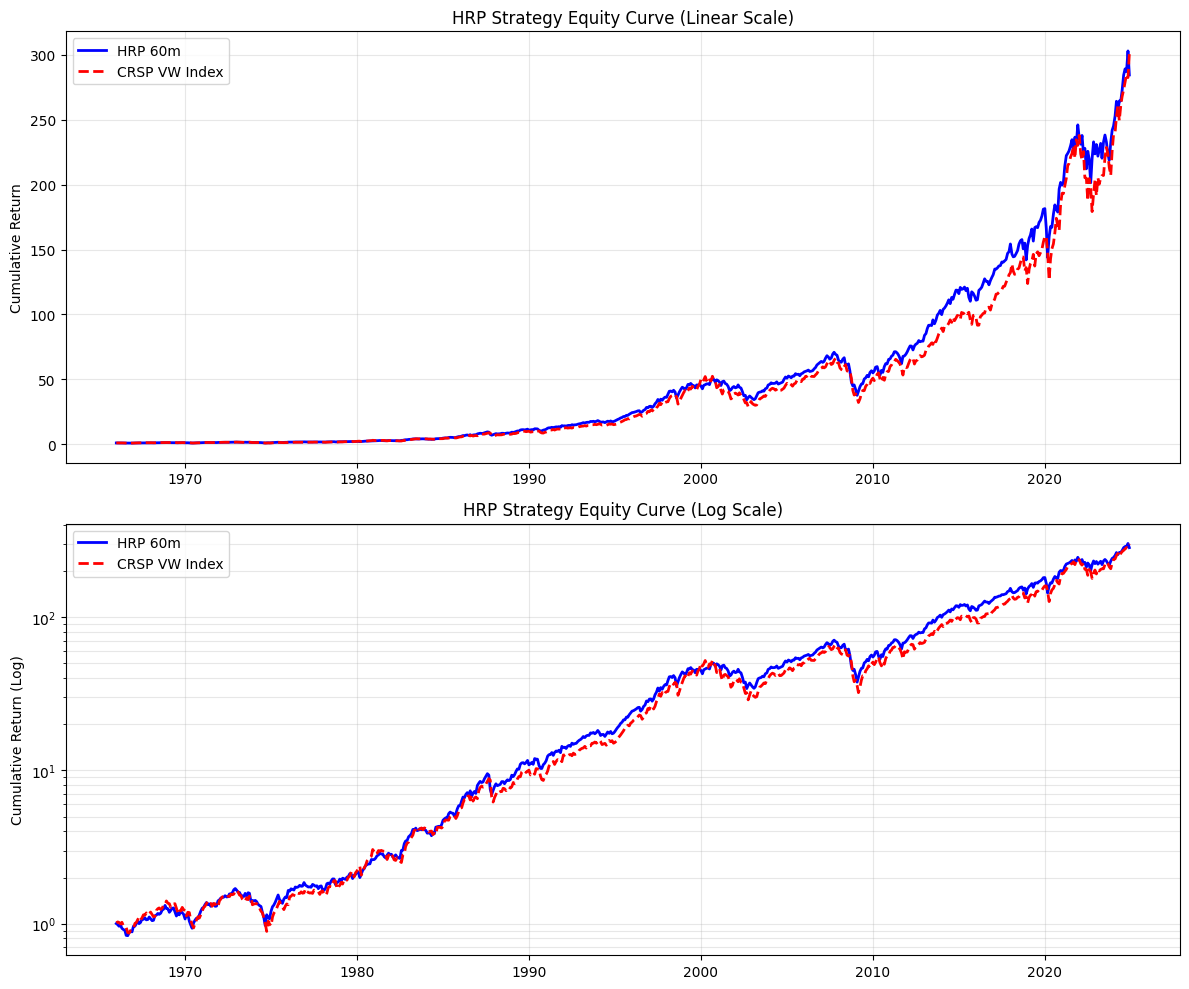

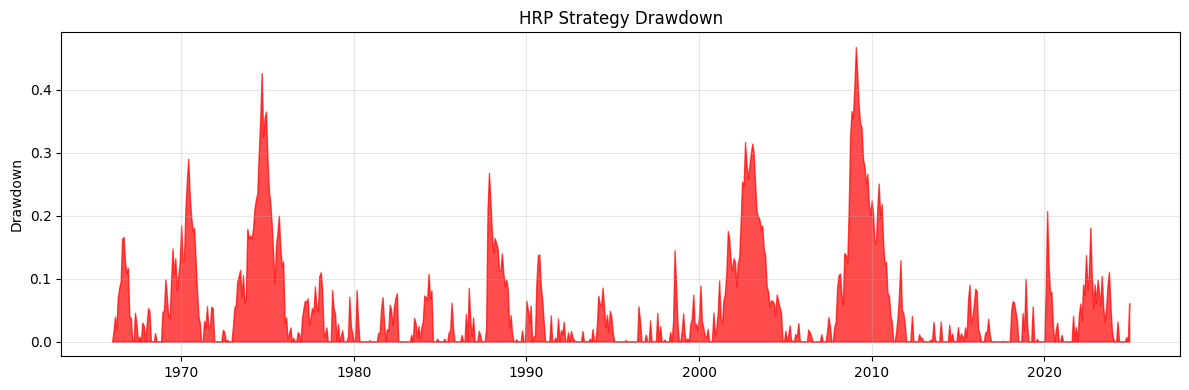


PERFORMANCE METRICS
Strategy                     HRP 60m
Total Excess Return       271.279169
Annualized Excess Return    0.055691
Sharpe Ratio                0.444342
Volatility (Ann.)           0.139344
Max Drawdown                0.467944
Calmar Ratio                0.214804
Win Rate                    0.628531
Avg Win                     0.032284
Avg Loss                   -0.030866
Best Month                  0.175064
Worst Month                -0.193393
Total Months              708.000000
2026-01-07 21:36:54,415 - HRP_Agent - INFO - [OK] Metrics saved to /workspace/HRP/Super_Agent_Output/final_metrics.csv


In [5]:
# Step 3: Backtest & Performance Metrics

# Load pre-computed strategy returns (in case Step 2 was skipped)
strategy_returns_path = os.path.join(super_agent_dir, 'hrp_strategy_returns.csv')
if os.path.exists(strategy_returns_path):
    print(f"Loading strategy returns from {strategy_returns_path}...")
    strategy_returns = pd.read_csv(strategy_returns_path, index_col=0, parse_dates=True).squeeze()

# Load risk-free rate if not already defined
if 'rf_monthly_aligned' not in dir():
    prep_path = os.path.join(project_root, 'DATA', 'CRSP')
    rf_monthly_aligned = hrp_data.load_risk_free_rate(prep_path, strategy_returns.index, start_date_str='1960-01-01')

# Load market returns (CRSP VW Index)
vw_returns_path = os.path.join(project_root, 'DATA', 'CRSP', 'CRSP_value_weighted_returns.csv')
df_vw = pd.read_csv(vw_returns_path, parse_dates=['date']).set_index('date').sort_index()
market_col = 'vwretd' if 'vwretd' in df_vw.columns else df_vw.columns[0]
market_returns = df_vw[market_col].dropna()

metrics_df = hrp_pipeline.run_backtest(
    strategy_returns, 
    rf_monthly_aligned, 
    super_agent_dir,
    market_returns=market_returns
)

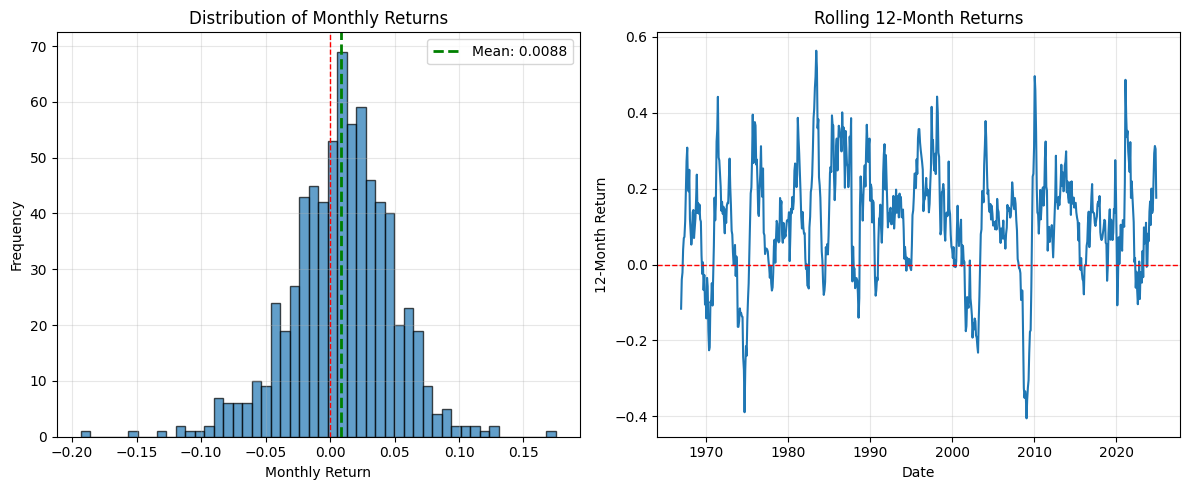

MONTHLY RETURNS DISTRIBUTION STATISTICS
Period: 1965-12 to 2024-12 (709 months)

Metric                     HRP Strategy      CRSP VW Index
------------------------------------------------------------
Mean (Monthly)                  0.883%            0.907%
Mean (Annualized)               10.59%            10.88%
Std (Monthly)                   4.023%            4.519%
Std (Annualized)                13.93%            15.65%
Skewness                         -0.403             -0.507
Excess Kurtosis                   1.758              1.756
Min (Monthly)                  -19.34%           -22.54%
Max (Monthly)                   17.51%            16.56%
------------------------------------------------------------

Interpretation:
  • HRP Strategy has MORE POSITIVE skew (-0.403 vs -0.507)
    → Fewer extreme negative returns, more upside potential
  • HRP Strategy has HIGHER kurtosis (1.758 vs 1.756)
    → Fatter tails, more frequent extreme events

Jarque-Bera Normality Test:
  • HRP St

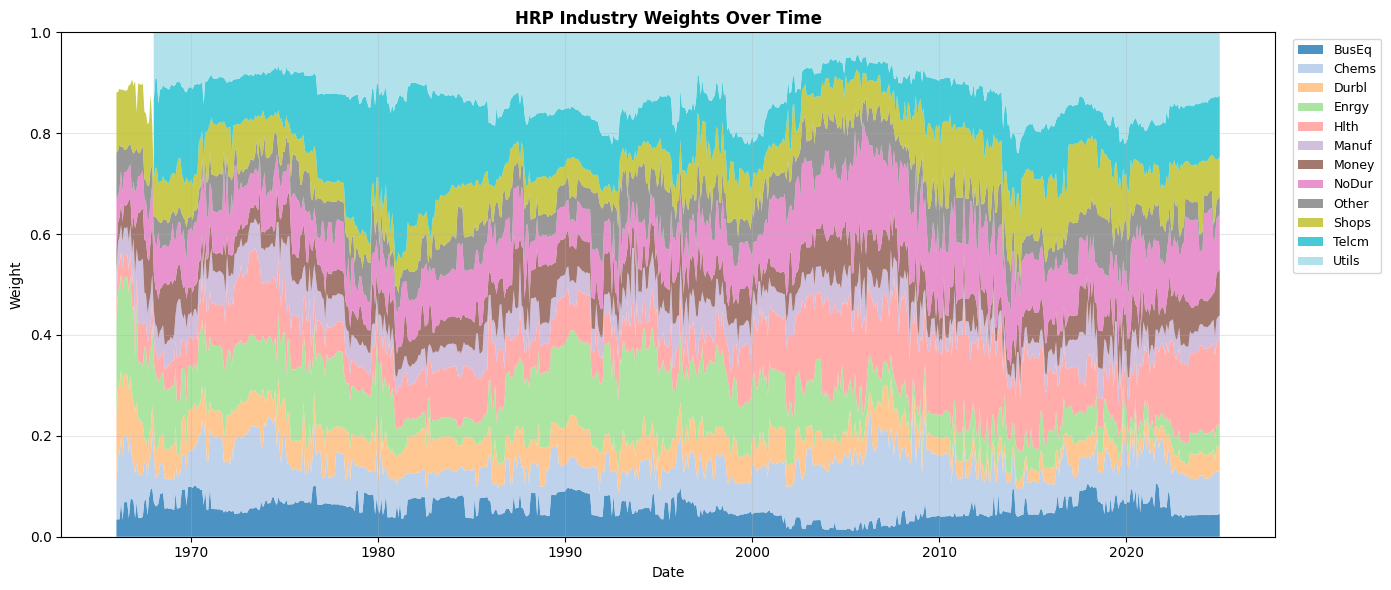


HRP INDUSTRY WEIGHTS SUMMARY

Industry         Mean      Std      Min      Max
--------------------------------------------------
BusEq            5.6%     2.1%     1.2%    10.5%
Chems            9.0%     3.5%     4.2%    21.8%
Durbl            5.6%     2.2%     1.3%    13.7%
Enrgy            9.6%     4.7%     1.7%    20.4%
Hlth            10.2%     4.4%     3.5%    21.8%
Manuf            5.3%     2.0%     2.2%    14.1%
Money            6.1%     2.1%     2.2%    12.2%
NoDur           10.2%     3.5%     4.9%    23.6%
Other            6.1%     2.6%     2.2%    11.8%
Shops            8.2%     3.3%     3.3%    17.3%
Telcm           11.5%     5.7%     2.2%    32.2%
Utils           13.1%     4.2%     4.4%    23.9%

STOCK-LEVEL WEIGHTS (Final Decomposed)


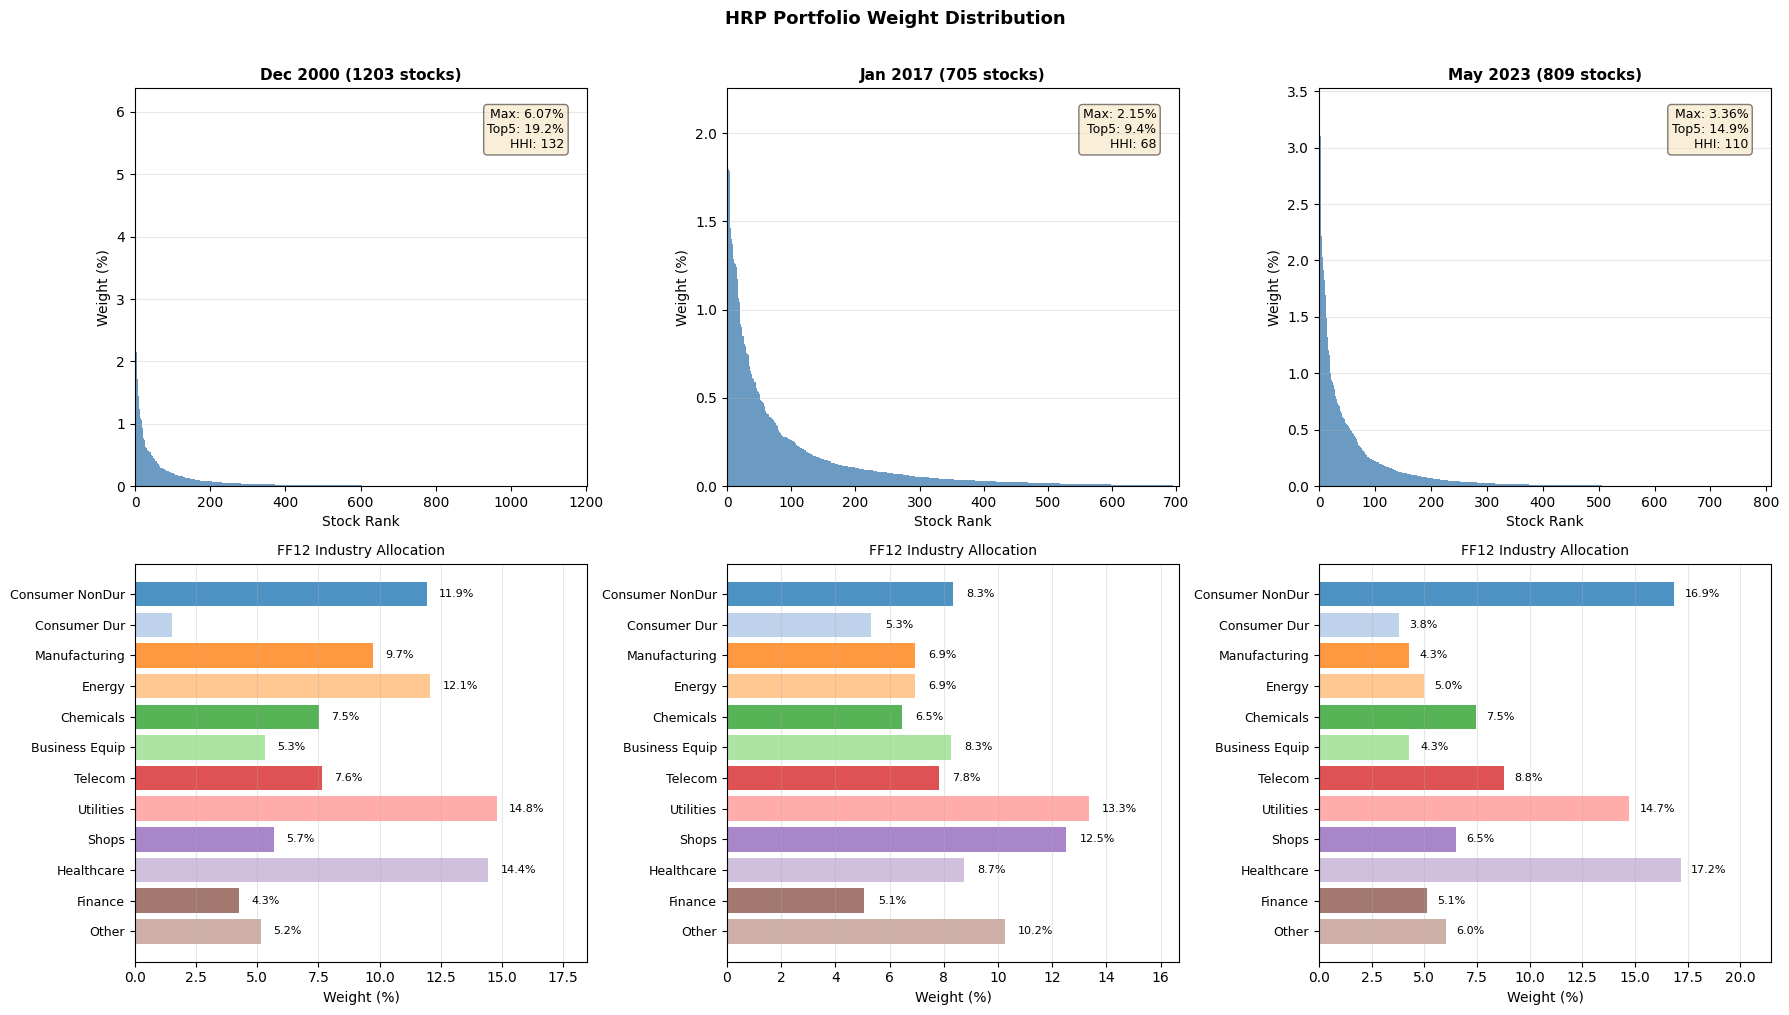


Weight Distribution Summary (3 Sample Months):

  Dec 2000: 1203 stocks
    Max: 6.07%, Top5: 19.21%
    Top 3 Industries: Utilities=14.8%, Healthcare=14.4%, Energy=12.1%

  Jan 2017: 705 stocks
    Max: 2.15%, Top5: 9.40%
    Top 3 Industries: Utilities=13.3%, Shops=12.5%, Other=10.2%

  May 2023: 809 stocks
    Max: 3.36%, Top5: 14.92%
    Top 3 Industries: Healthcare=17.2%, Consumer NonDur=16.9%, Utilities=14.7%

Computing industry exposures over time...


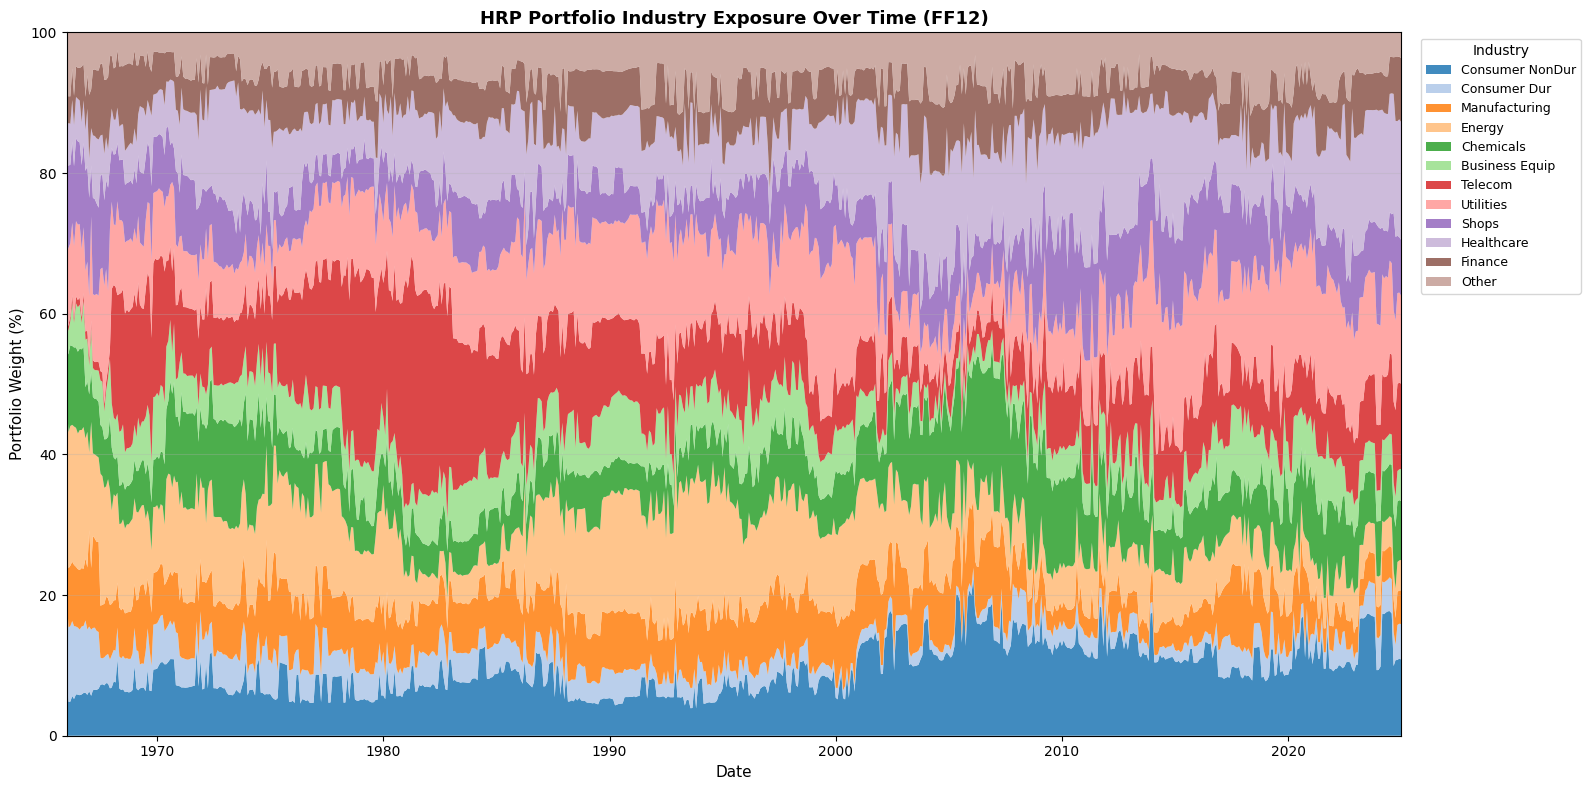


Average Industry Allocation (Full Period):
  Utilities         : 11.9%
  Telecom           : 11.2%
  Healthcare        : 11.1%
  Energy            : 10.4%
  Consumer NonDur   : 9.4%
  Chemicals         : 8.4%
  Shops             : 8.0%
  Manufacturing     : 7.2%
  Other             : 6.6%
  Finance           : 6.3%
  Business Equip    : 5.9%
  Consumer Dur      : 3.5%


In [6]:
# Step 4: Return Distribution & Weights Analysis
import matplotlib.pyplot as plt
import numpy as np

# Plot returns distribution histogram
hrp_pipeline.plot_monthly_returns_distribution(strategy_returns, super_agent_dir)

# Load CRSP VW returns for comparison
vw_returns_path = os.path.join(project_root, 'DATA', 'CRSP', 'CRSP_value_weighted_returns.csv')
df_vw = pd.read_csv(vw_returns_path, parse_dates=['date']).set_index('date').sort_index()
market_col = 'vwretd' if 'vwretd' in df_vw.columns else df_vw.columns[0]
crsp_returns = df_vw[market_col].dropna()

# Print distribution statistics comparison (mean, std, skewness, kurtosis, Jarque-Bera)
hrp_analytics.print_distribution_comparison(strategy_returns, crsp_returns)

# Sharpe Ratio Comparison (HRP vs CRSP VW)
hrp_analytics.print_sharpe_comparison(strategy_returns, crsp_returns, rf_monthly_aligned)

# ═══════════════════════════════════════════════════════════════════════════════
# HRP INDUSTRY WEIGHTS OVER TIME (Stage 2: HRP Allocation Across 12 Industries)
# ═══════════════════════════════════════════════════════════════════════════════
print("\n" + "="*70)
print("HRP INDUSTRY WEIGHTS OVER TIME")
print("="*70)
industry_weights_path = os.path.join(super_agent_dir, 'hrp_industry_weights.csv')
hrp_analytics.plot_industry_hrp_weights(industry_weights_path, super_agent_dir)

# ═══════════════════════════════════════════════════════════════════════════════
# STOCK-LEVEL WEIGHTS ANALYSIS (Final Decomposed Weights)
# ═══════════════════════════════════════════════════════════════════════════════

# Load final stock-level HRP weights (industry_weight × within_industry_weight)
weights_path = os.path.join(super_agent_dir, 'all_hrp_weights.csv')
hrp_weights_df = pd.read_csv(weights_path, index_col=0, parse_dates=True)

# Load PERMNO to FF12 mapping for stock-level analysis
permno_to_ff12 = hrp_analytics.load_permno_to_ff12_mapping(project_root)

# Plot stock-level weight distributions for 3 sample months
print("\n" + "="*70)
print("STOCK-LEVEL WEIGHTS (Final Decomposed)")
print("="*70)
hrp_analytics.plot_weight_distribution(
    hrp_weights_df, permno_to_ff12, super_agent_dir,
    sample_dates=['2000-12-31', '2017-01-31', '2023-05-31']
)

# Plot industry exposure over time (from stock-level weights)
industry_df = hrp_analytics.plot_industry_exposure_over_time(
    hrp_weights_df, permno_to_ff12, super_agent_dir
)

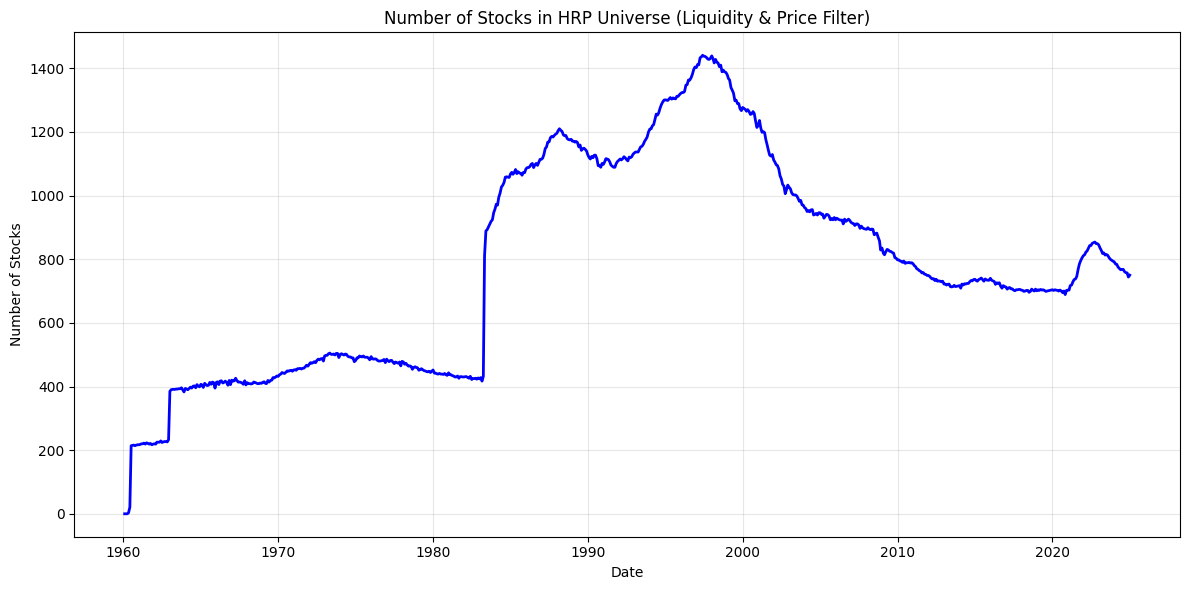

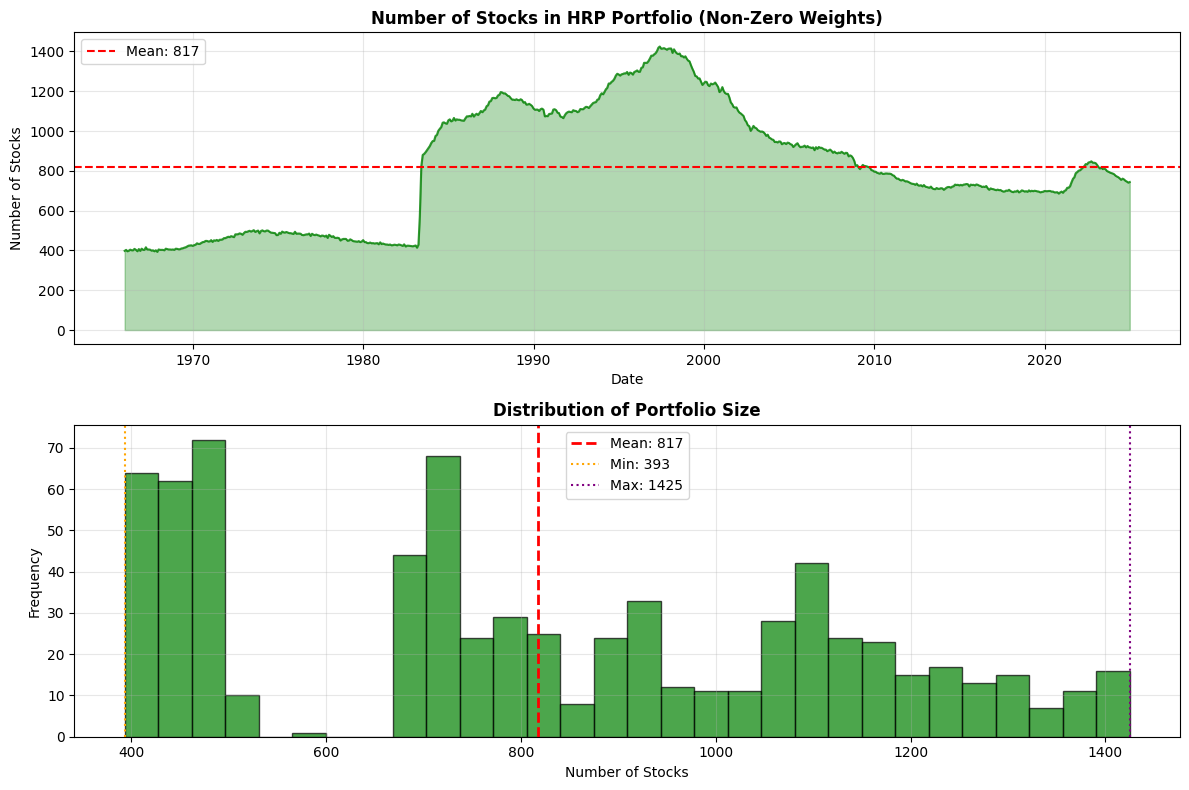


Portfolio Size Statistics:
  Mean:   817.3 stocks
  Median: 786.0 stocks
  Min:    393 stocks
  Max:    1425 stocks
  Std:    301.2 stocks


In [7]:
# Step 5: Universe Size & Portfolio Size Analysis

# Plot universe size (stocks passing liquidity/price filter)
hrp_analytics.plot_universe_size(universe_flags, super_agent_dir)

# Plot portfolio size (stocks with non-zero weights) - reuses hrp_weights_df from Step 4
portfolio_counts = hrp_analytics.plot_portfolio_size(hrp_weights_df, super_agent_dir)

✓ Loading industry ETF returns from saved file...
  Shape: 775 months × 12 industries

INDUSTRY HRP DENDROGRAM: 2023-12-29
NOTE: Two-stage HRP uses SINGLE LINKAGE (nearest neighbor clustering)
      Better suited for 12 industries vs. Ward's balanced variance approach
      Dendrogram shows N=12 industries (statistically valid: N < T=60)


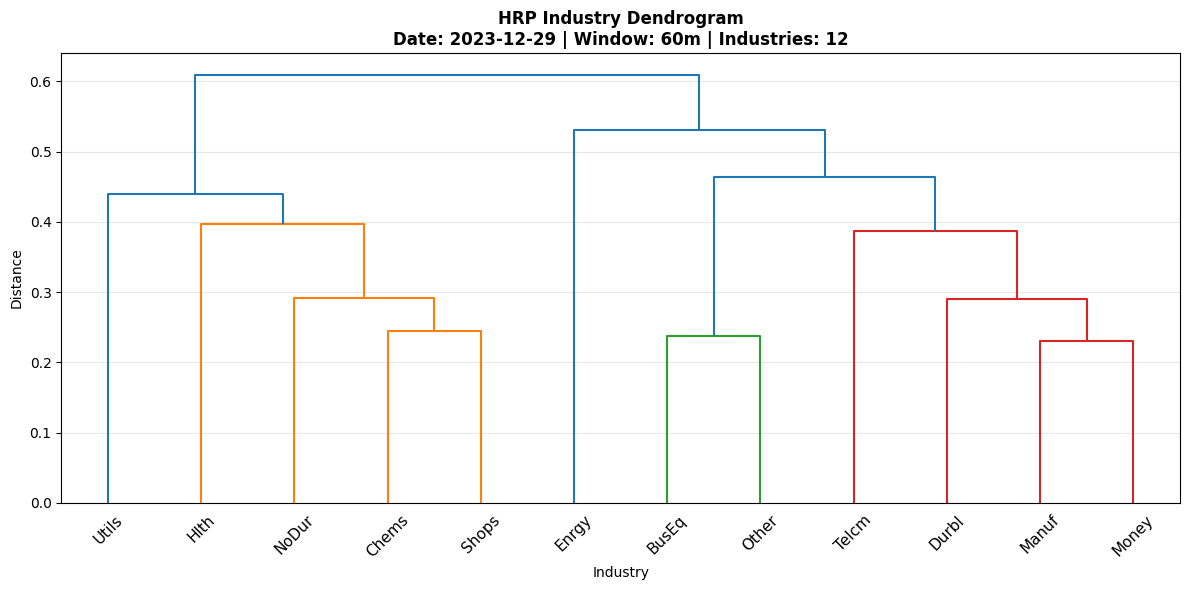

In [8]:
# Step 6: HRP Industry Dendrogram Visualization
# Now shows 12 industries instead of 600+ stocks - much cleaner and interpretable

# Load industry ETF returns from saved file (computed in Step 2)
# This avoids recomputing the value-weighted industry ETFs
industry_returns_path = os.path.join(super_agent_dir, 'industry_etf_returns.csv')

if os.path.exists(industry_returns_path):
    print("✓ Loading industry ETF returns from saved file...")
    industry_returns = pd.read_csv(industry_returns_path, index_col=0, parse_dates=True)
    print(f"  Shape: {industry_returns.shape[0]} months × {industry_returns.shape[1]} industries")
else:
    # Fallback: compute if file doesn't exist (first run)
    print("[!] Industry ETF returns file not found. Computing from scratch...")
    industry_returns, _, _ = hrp_data.compute_industry_etf_returns(
        df_universe, returns_all, universe_flags, min_stocks_per_industry=3
    )

# Plot dendrogram for the last rebalance date of 2023
target_year = 2023
dates_2023 = [d for d in valid_rebal_dates if d.year == target_year]

if dates_2023:
    plot_date = dates_2023[-1]
    print(f"\n{'='*70}")
    print(f"INDUSTRY HRP DENDROGRAM: {plot_date.date()}")
    print(f"{'='*70}")
    print("NOTE: Two-stage HRP uses SINGLE LINKAGE (nearest neighbor clustering)")
    print("      Better suited for 12 industries vs. Ward's balanced variance approach")
    print("      Dendrogram shows N=12 industries (statistically valid: N < T=60)")
    
    hrp_analytics.plot_industry_dendrogram(
        industry_returns,
        plot_date,
        window,
        super_agent_dir
    )
else:
    print(f"No rebalance dates found for year {target_year}")

# Regime-Based HRP Strategy with XGBoost Prediction

## Prediction Goal: Will NEXT MONTH be Bear or Bull?

The XGBoost model predicts whether the upcoming month will be:
- **Bear (0)**: Negative expected returns, elevated volatility, correlation convergence
- **Bull/Consolidation (1)**: Positive expected returns, normal volatility, diversification works

## 5-Phase Implementation Plan

### Phase 1: Data Construction (HMM Input)
- Use **HRP strategy returns** (not CRSP VW index) — fits regimes to the actual traded strategy
- **3-Feature HMM Input** (all expanding Z-scored for no look-ahead bias):
  1. **Log Returns**: $r_t = \ln(1 + R_t)$
  2. **Downside Deviation** (rolling 6-month window): $\sigma^-_t = \text{std}(\min(r_{t-W:t}, 0))$
  3. **Michigan Consumer Sentiment YoY Change** (lagged 1M for publication delay)
- **Expanding Z-score** (strictly ex-ante): $z_t = \frac{x_t - \bar{x}_{1:t-1}}{\sigma_{1:t-1}}$

### Phase 2: Regime Identification (HMM)
- Fit `hmmlearn.GaussianHMM` with **2 states** using **expanding window** (min 240 months = 20 years, refit every 12 months)
- **Forward-Only Filter**: Compute $P(q_t | O_{1:t})$ using forward algorithm ONLY
- **Critical**: `hmmlearn.predict_proba()` uses forward-backward (smoothed posteriors = look-ahead bias!) — we implement a **custom forward filter** to avoid data leakage
- **State Sorting**: State 0 = Lower Mean Return (Bear), State 1 = Higher Mean Return (Bull)

### Phase 3: Walk-Forward Backtesting (Predict Bear/Bull)
- **13 Candidate Features**: Market (`dispersion_z`, `amihud_z`, `bab_z`, `avg_pairwise_corr_z`), Macro (`credit_spread`, `term_spread`, `cpi_vol`, `m2_growth`, `unrate_trend`, `valuation_spread_z`), HRP Momentum (`hrp_mom_1m_z`, `hrp_mom_3m_z`, `hrp_mom_12m_z`)
- **Purged Time-Series CV** for all cross-validation (`purge_gap=12` months, `embargo_pct=1%`)
- **Feature selection INSIDE walk-forward loop** — avoids look-ahead bias
- **Hyperparameter tuning INSIDE walk-forward loop** (20 Optuna trials per refit)
- **Winsorization INSIDE walk-forward loop** — bounds computed from training data only
- Start at Month 120 (10 years after HMM starts), refit every 12 months

### Phase 4: HRP Integration (GROSS Returns)
- **Two-Fund Separation**: $r_{portfolio} = L_t \times r_{HRP} + (1-L_t) \times r_f$
- **P(Bull) Scaled Strategy**: $L_t = P(Bull_t) \times \frac{1}{\bar{P}(Bull)}$ ensures mean leverage ≈ 1
- **Leverage interpretation**: $L > 1$ = borrow at $r_f$; $L < 1$ = hold T-Bills defensively
- **GROSS returns**: No transaction costs, borrow at $r_f$ (no financing spread)

### Phase 5: Transaction Cost Analysis (NET Returns)
- **Inner Cost** (HRP Rebalancing): Drift-adjusted turnover × cost per trade
  $$\text{inner}_t = L_t \times \sum_i |w_{i,t}^{target} - w_{i,t}^{drifted}| \times C_{bps}$$
- **Outer Cost** (Leverage Overlay): Both sides of HRP ↔ T-Bill trade
  $$\text{outer}_t = 2 \times |L_t - L_{t-1}| \times C_{bps}$$
- **Financing Cost** (Asymmetric): Pay spread only when leveraged ($L > 1$)
  $$\text{financing}_t = \max(L_t - 1, 0) \times \text{spread}_{bps}$$
- **NET Returns**: $r_{NET} = r_{GROSS} - \text{inner} - \text{outer} - \text{financing}$

2026-01-07 21:37:11,502 - HRP_Agent - INFO - [OK] hrp_features: CuPy GPU available
2026-01-07 21:37:11,604 - HRP_Agent - INFO - [OK] hrp_hmm: CuPy GPU available
2026-01-07 21:37:11,627 - HRP_Agent - INFO - [OK] hrp_ml: CuPy GPU available
2026-01-07 21:37:11,724 - HRP_Agent - INFO - [!] XGBoost GPU not available (fallback to CPU detected)
2026-01-07 21:37:11,744 - HRP_Agent - INFO - [OK] hrp_strategy: CuPy GPU available
✓ Loaded configuration from /workspace/HRP/config.yaml
✓ Random seeds set to 42
ML CONFIGURATION (from config.yaml)
HMM: min_train=120, refit_freq=12
ML:  min_train=120, optuna_trials=50
Strategy: tx_cost=10bps, bear_alloc=0.5

✓ Market Returns: 1188 months
✓ Loaded BAA from BAA.csv
✓ Loaded DGS10 from DGS10.csv
✓ Loaded CPI from CPIAUCSL.csv
✓ Loaded M2SL from M2SL.csv
✓ Loaded UNRATE from UNRATE.csv
✓ Loaded TB3MS from TB3MS.csv
✓ Compustat data loaded
2026-01-07 21:37:14,625 - HRP_Agent - INFO - Computing advanced features...
2026-01-07 21:37:14,773 - HRP_Agent - WARN

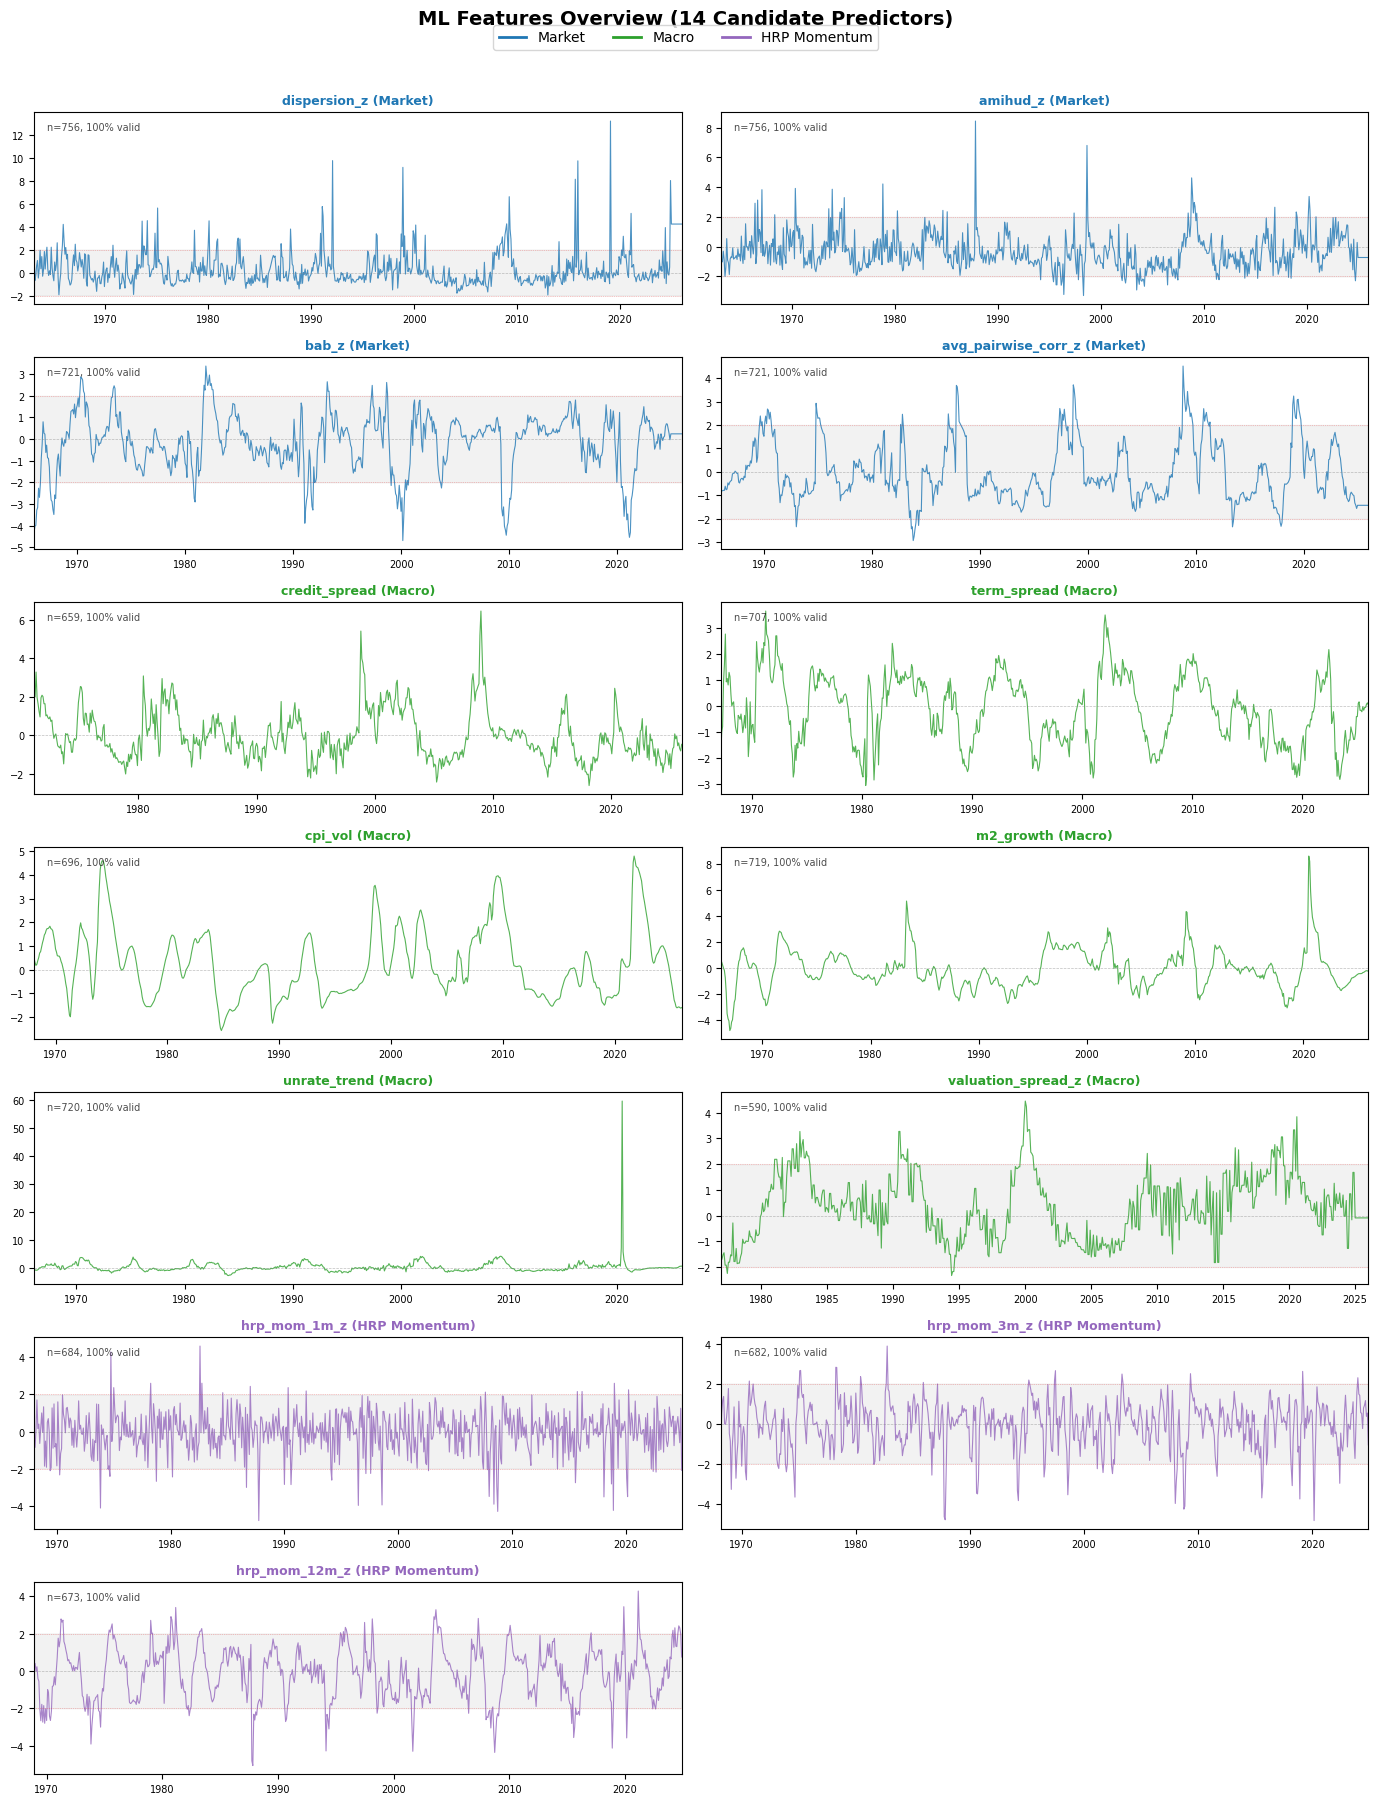

In [9]:
# ═══════════════════════════════════════════════════════════════════════════════
# ML PHASES: DATA PREPARATION
# ═══════════════════════════════════════════════════════════════════════════════
# Note: This cell reuses data loaded in Steps 1-4 (returns_all, universe_flags, etc.)
# Only loads ML-specific modules and computes ML features

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import ML modules
import hrp_features
import hrp_hmm
import hrp_ml
import hrp_strategy
import hrp_viz

# Reload config to get ML parameters
config = hrp_setup.load_config(project_root)

# Extract ML config sections
hmm_config = config.get('hmm', {})
ml_config = config.get('ml', {})
strategy_config = config.get('strategy', {})

print("="*70)
print("ML CONFIGURATION (from config.yaml)")
print("="*70)
print(f"HMM: min_train={hmm_config.get('min_train', 60)}, refit_freq={hmm_config.get('refit_freq', 12)}")
print(f"ML:  min_train={ml_config.get('min_train_months', 120)}, optuna_trials={ml_config.get('optuna_trials', 50)}")
print(f"Strategy: tx_cost={strategy_config.get('tx_cost_bps', 10)}bps, bear_alloc={strategy_config.get('bear_allocation', 0.5)}")

# Load CRSP VW returns for HMM (market_returns loaded in Step 3, but need full series)
vw_returns_path = os.path.join(project_root, 'DATA', 'CRSP', 'CRSP_value_weighted_returns.csv')
df_vw = pd.read_csv(vw_returns_path, parse_dates=['date']).set_index('date').sort_index()
market_col = 'vwretd' if 'vwretd' in df_vw.columns else df_vw.columns[0]
market_returns_full = df_vw[market_col].dropna()
market_returns_full = market_returns_full.resample('ME').last()
full_range = pd.date_range(start=market_returns_full.index.min(), end=market_returns_full.index.max(), freq='ME')
market_returns_full = market_returns_full.reindex(full_range).ffill()
print(f"\n✓ Market Returns: {len(market_returns_full)} months")

# Compute ML features (uses df_ml_universe from Step 1)
fred_path = os.path.join(project_root, 'DATA', 'FRED')
macro_df = hrp_data.load_fred_data(fred_path, start_date_str='1960-01-01')

# Load Compustat for valuation spread
df_merged_comp = None
comp_path = os.path.join(project_root, 'DATA', 'Compustat', 'compustat_selected_columns.csv')
if os.path.exists(comp_path):
    comp_df = pd.read_csv(comp_path, parse_dates=['datadate'])
    comp_df = comp_df.rename(columns={'LPERMNO': 'PERMNO'})
    if 'seqq' in comp_df.columns:
        comp_df['BOOK_EQUITY'] = comp_df['seqq']
        comp_df = comp_df[comp_df['BOOK_EQUITY'].notna() & (comp_df['BOOK_EQUITY'] > 0)]
        df_merged_comp = df_ml_universe.merge(
            comp_df[['PERMNO', 'datadate', 'BOOK_EQUITY']], 
            left_on=['PERMNO', 'DATE'], right_on=['PERMNO', 'datadate'], how='left'
        )
        print(f"✓ Compustat data loaded")

ml_features = hrp_features.compute_all_features(df_ml_universe, macro_df, df_merged_comp)
print(f"✓ ML Features (Market/Macro): {ml_features.shape[0]} obs × {ml_features.shape[1]} features")

# Reuse hrp_weights_df from Step 4 (rename for ML phases)
hrp_weights = hrp_weights_df.copy()
print(f"✓ HRP Weights: {hrp_weights.shape[0]} months × {hrp_weights.shape[1]} assets")

# ═══════════════════════════════════════════════════════════════════════════════
# COMPUTE HRP MOMENTUM FEATURES (1M, 3M, 12M Z-scored)
# ═══════════════════════════════════════════════════════════════════════════════
# These are strategy-specific features that capture time-series momentum
# in the HRP portfolio itself - useful for predicting regime persistence
# NOTE: Using 24-month Z-score window (not 60) to minimize data loss
#       12M momentum + 24M zscore + 1 shift = ~37 months burn-in (acceptable)

hrp_momentum_features = hrp_features.compute_hrp_momentum_features(strategy_returns, zscore_window=24)

# Normalize dates to month-end for merging
hrp_momentum_features.index = hrp_momentum_features.index.to_period('M').to_timestamp('M')
ml_features.index = pd.to_datetime(ml_features.index).to_period('M').to_timestamp('M')

# ═══════════════════════════════════════════════════════════════════════════════
# FIX: Remove duplicate dates after month-end normalization
# Multiple dates in the same month (e.g., 1960-01-29, 1960-01-31) become duplicates
# when converted to month-end. Keep only the last occurrence.
# ═══════════════════════════════════════════════════════════════════════════════
n_dups_before = ml_features.index.duplicated().sum()
if n_dups_before > 0:
    print(f"  ⚠ Removing {n_dups_before} duplicate dates after month-end normalization")
    ml_features = ml_features[~ml_features.index.duplicated(keep='last')]

# Merge HRP momentum features with other ML features
ml_features = ml_features.join(hrp_momentum_features, how='left')

print(f"✓ ML Features (with HRP Momentum): {ml_features.shape[0]} obs × {ml_features.shape[1]} features")
print(f"  Columns: {list(ml_features.columns)}")

# ═══════════════════════════════════════════════════════════════════════════════
# LOAD MICHIGAN CONSUMER SENTIMENT (for HMM Phase 1) 
# ═══════════════════════════════════════════════════════════════════════════════
# Sentiment is lagged 1 month in hrp_hmm to account for publication delay
umich_sentiment = hrp_hmm.load_umich_sentiment(fred_path)

print("\n" + "="*70)
print("DATA PREPARATION COMPLETE")
print("="*70)

# ═══════════════════════════════════════════════════════════════════════════════
# VISUALIZE ALL 14 ML FEATURES (Mini Charts)
# ═══════════════════════════════════════════════════════════════════════════════
fig = hrp_viz.plot_ml_features_overview(
    ml_features, 
    save_path=os.path.join(super_agent_dir, 'ml_features_overview.png')
)
plt.show()

PHASE 1: DATA CONSTRUCTION
HRP Strategy Returns: 709 months
Date Range: 1965-12-31 to 2024-12-31
2026-01-07 21:37:23,380 - HRP_Agent - INFO - Preparing HMM data from 709 observations
2026-01-07 21:37:23,382 - HRP_Agent - INFO - Using EXPANDING Z-SCORE (no look-ahead bias)
2026-01-07 21:37:23,488 - HRP_Agent - INFO - Adding UMICH Consumer Sentiment to HMM features
2026-01-07 21:37:23,491 - HRP_Agent - INFO - Computed sentiment features: sent_change, sent_gap (lagged 1M for publication)
2026-01-07 21:37:23,493 - HRP_Agent - INFO - Sentiment coverage: 707 months
2026-01-07 21:37:23,495 - HRP_Agent - INFO - HMM input data: 703 observations after dropping NaN
2026-01-07 21:37:23,496 - HRP_Agent - INFO - Date range: 1966-05-31 to 2024-11-29
2026-01-07 21:37:23,499 - HRP_Agent - INFO - Added sent_change_z to HMM input (3 features total)
2026-01-07 21:37:23,501 - HRP_Agent - INFO - After expanding z-score burn-in: 679 observations
2026-01-07 21:37:23,502 - HRP_Agent - INFO - HMM features: ['lo

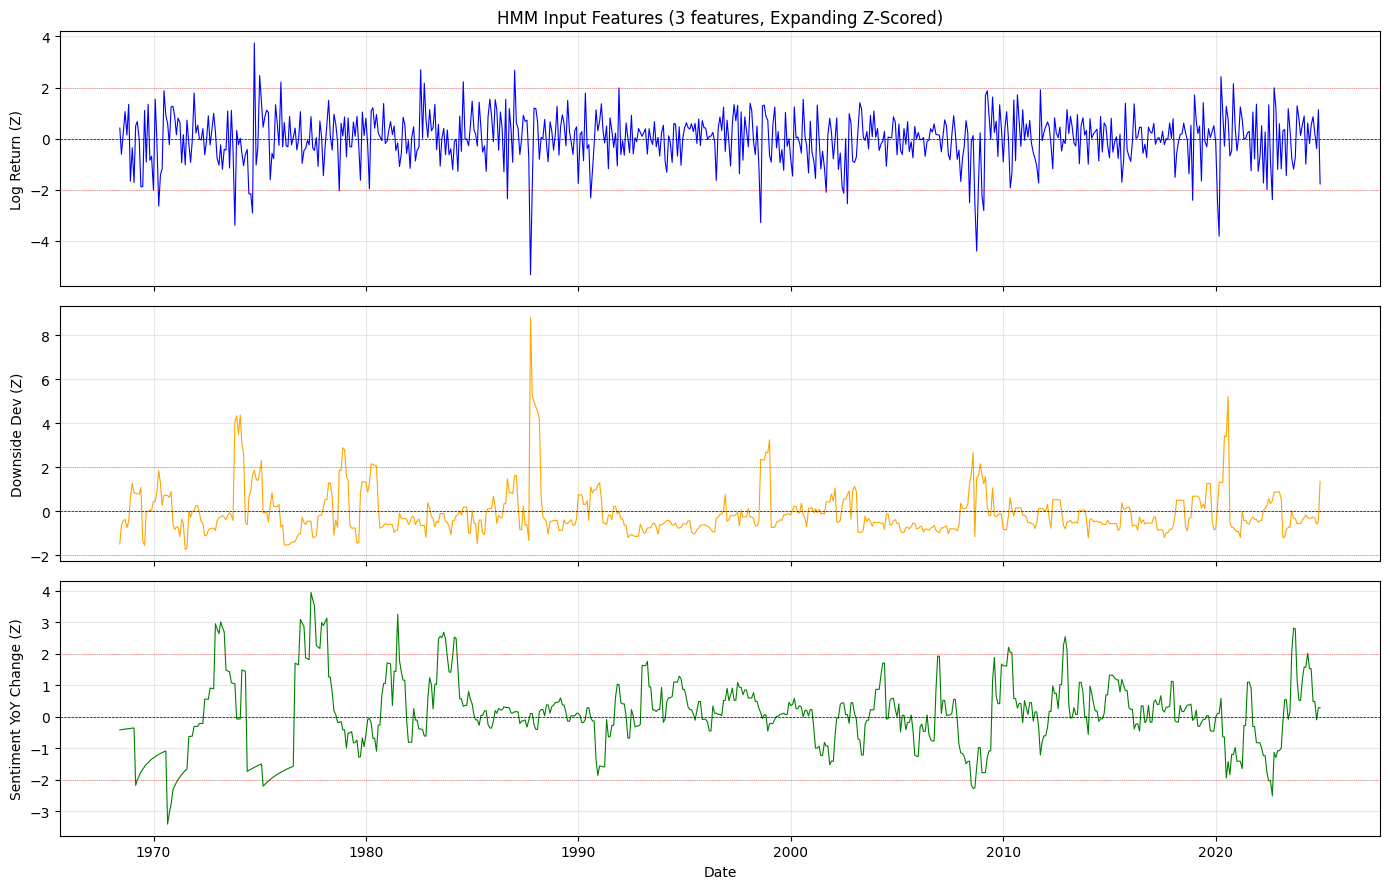


✓ Phase 1 Complete: HMM input prepared (679 observations)
  Features: ['log_return_z', 'downside_dev_z', 'sent_change_z']
  NOTE: Using HRP strategy returns + UMICH Consumer Sentiment (lagged 1M)


In [10]:
# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 1: DATA CONSTRUCTION (Ground Truth Definition)
# ═══════════════════════════════════════════════════════════════════════════════

print("="*70)
print("PHASE 1: DATA CONSTRUCTION")
print("="*70)

# Use HRP strategy returns for HMM regime detection (instead of CRSP VW index)
# This fits regimes to the actual strategy being traded
hrp_returns_for_hmm = strategy_returns.copy()
hrp_returns_for_hmm.index = pd.to_datetime(hrp_returns_for_hmm.index)

print(f"HRP Strategy Returns: {len(hrp_returns_for_hmm)} months")
print(f"Date Range: {hrp_returns_for_hmm.index.min().date()} to {hrp_returns_for_hmm.index.max().date()}")

# Prepare HMM input data (log returns + downside deviation + sentiment YoY change)
# umich_sentiment loaded in DATA PREPARATION cell above
downside_window = hmm_config.get('downside_window', 12)
df_hmm_raw, df_hmm = hrp_hmm.prepare_hmm_data(
    hrp_returns_for_hmm, 
    downside_window=downside_window,
    sentiment=umich_sentiment  # Adds sent_change_z as 3rd HMM feature
)

# Data quality check (verifies no missing values in HMM features)
print()
hrp_hmm.check_hmm_data_quality(df_hmm)

# Visualize HMM input
fig = hrp_viz.plot_hmm_input(df_hmm)
plt.show()

print(f"\n✓ Phase 1 Complete: HMM input prepared ({len(df_hmm)} observations)")
print(f"  Features: {list(df_hmm.columns)}")
print("  NOTE: Using HRP strategy returns + UMICH Consumer Sentiment (lagged 1M)")

PHASE 2: REGIME IDENTIFICATION (HMM)
Using TRUE FILTERED probabilities: P(q_t | O_1:t)
Forward algorithm ONLY - no backward pass, no look-ahead bias

NOTE: hmmlearn's predict_proba() uses forward-backward (smoothed posteriors)
      which leaks future information. We implement forward-only filter.

Config: min_train=120, refit_freq=12
2026-01-07 21:37:23,790 - HRP_Agent - INFO - ======================================================================
2026-01-07 21:37:23,792 - HRP_Agent - INFO - EXPANDING-WINDOW HMM FITTING (TRUE FILTERED PROBABILITIES)
2026-01-07 21:37:23,793 - HRP_Agent - INFO - ======================================================================
2026-01-07 21:37:23,794 - HRP_Agent - INFO - Using FORWARD-ONLY filter: P(q_t | O_1:t) - NO look-ahead bias
2026-01-07 21:37:23,796 - HRP_Agent - INFO - Min training: 120 months, Refit frequency: 12 months


2026-01-07 21:38:20,728 - HRP_Agent - INFO - Regime labels: 559 months (138 Bear, 421 Bull)



df_regimes columns: ['regime', 'prob_bear', 'prob_bull', 'log_return', 'downside_dev', 'regime_label']
Regime value counts: {1: 421, 0: 138}

Regime Statistics:

Bear:
  Months: 138 (24.7%)
  Annualized Return: 2.53%
  Expected Duration: 8.6 months

Bull:
  Months: 421 (75.3%)
  Annualized Return: 14.51%
  Expected Duration: 24.8 months

Transition Matrix:
           To Bear  To Bull
From Bear    0.883    0.117
From Bull    0.040    0.960


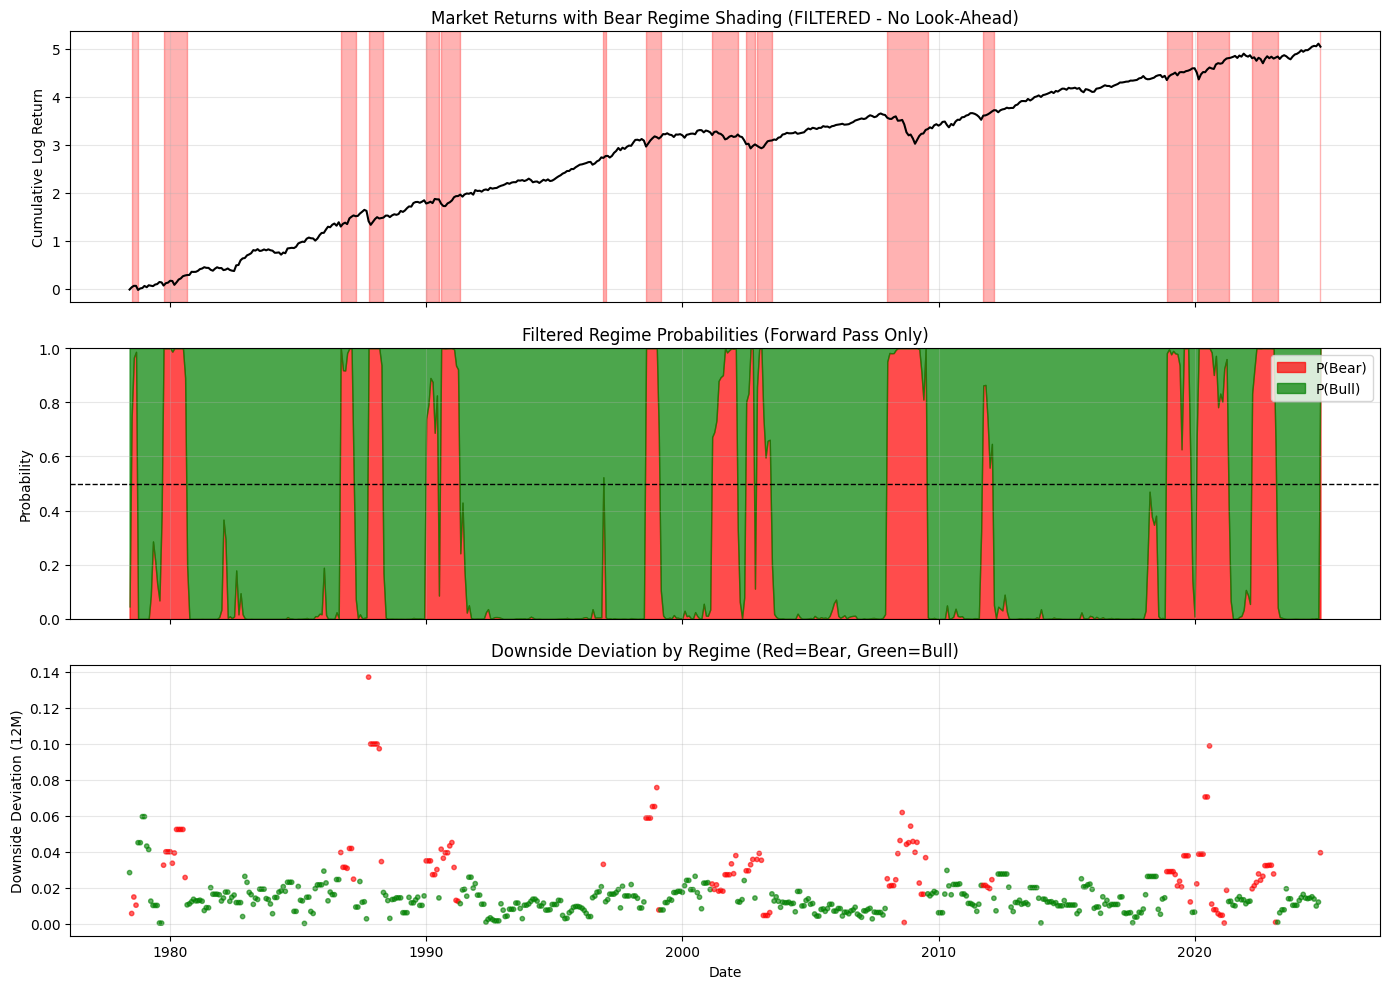


✓ Phase 2 Complete: 559 months labeled (TRUE filtered probabilities)


In [11]:
# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 2: REGIME IDENTIFICATION (HMM) - TRUE FILTERED PROBABILITIES
# ═══════════════════════════════════════════════════════════════════════════════

print("="*70)
print("PHASE 2: REGIME IDENTIFICATION (HMM)")
print("="*70)
print("Using TRUE FILTERED probabilities: P(q_t | O_1:t)")
print("Forward algorithm ONLY - no backward pass, no look-ahead bias")
print("")
print("NOTE: hmmlearn's predict_proba() uses forward-backward (smoothed posteriors)")
print("      which leaks future information. We implement forward-only filter.")

# Configuration from config.yaml
HMM_MIN_TRAIN = hmm_config.get('min_train', 60)
HMM_REFIT_FREQ = hmm_config.get('refit_freq', 12)

print(f"\nConfig: min_train={HMM_MIN_TRAIN}, refit_freq={HMM_REFIT_FREQ}")

# Fit expanding-window HMM with TRUE filtered probabilities
df_regimes = hrp_hmm.fit_expanding_hmm(
    df_hmm, df_hmm_raw,
    min_train=HMM_MIN_TRAIN,
    refit_freq=HMM_REFIT_FREQ
)

# Debug: Check df_regimes structure
print(f"\ndf_regimes columns: {df_regimes.columns.tolist()}")
print(f"Regime value counts: {df_regimes['regime'].value_counts().to_dict()}")

# Get regime statistics
regime_stats = hrp_hmm.get_regime_statistics(df_regimes)

print(f"\nRegime Statistics:")
for regime_name in ['Bear', 'Bull']:
    stats = regime_stats[regime_name]
    print(f"\n{regime_name}:")
    print(f"  Months: {stats['months']} ({stats['pct']:.1%})")
    print(f"  Annualized Return: {stats['ann_return']:.2%}")
    print(f"  Expected Duration: {stats['expected_duration']:.1f} months")

print(f"\nTransition Matrix:")
print(regime_stats['transition_matrix'].round(3))

# Visualize regimes
fig = hrp_viz.plot_hmm_regimes(df_regimes, 
    save_path=os.path.join(super_agent_dir, 'phase2_hmm_regimes.png'))
plt.show()

print(f"\n✓ Phase 2 Complete: {len(df_regimes)} months labeled (TRUE filtered probabilities)")

In [12]:
# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 3: WALK-FORWARD BACKTESTING (Predict Bear/Bull for Next Month)
# ═══════════════════════════════════════════════════════════════════════════════
# Goal: At each time t, predict if t+1 is Bear (0) or Bull (1)

print("="*70)
print("PHASE 3: WALK-FORWARD BEAR/BULL PREDICTION")
print("="*70)
print("Goal: Predict if NEXT MONTH is Bear (0) or Bull (1)")

# ═══════════════════════════════════════════════════════════════════════════════
# DATA ALIGNMENT: Prepare features and target for walk-forward
# ═══════════════════════════════════════════════════════════════════════════════

# Normalize df_regimes index to month-end (fixes date format mismatch)
df_regimes_aligned = df_regimes.copy()
df_regimes_aligned.index = df_regimes_aligned.index.to_period('M').to_timestamp('M')

# Get available features from ml_features
FEATURE_COLS = [
    'dispersion_z', 'amihud_z', 'bab_z', 'avg_pairwise_corr_z',  # Market
    'credit_spread', 'term_spread', 'cpi_vol', 'm2_growth',      # Macro
    'unrate_trend', 'valuation_spread_z',                        # Macro (continued)
    'hrp_mom_1m_z', 'hrp_mom_3m_z', 'hrp_mom_12m_z'              # HRP Momentum
]
available_features = [f for f in FEATURE_COLS if f in ml_features.columns]
X_features = ml_features[available_features].dropna()

# Align features with regimes (y[t] = regime at t+1)
X_final, y_final = hrp_ml.align_features_with_regimes(X_features, df_regimes_aligned, lag=1)

print(f"\nDataset: {len(X_final)} obs, {len(available_features)} features")
print(f"Target: Bear={sum(y_final==0)}, Bull={sum(y_final==1)}")

# ═══════════════════════════════════════════════════════════════════════════════
# WALK-FORWARD CONFIGURATION (from config.yaml)
# ═══════════════════════════════════════════════════════════════════════════════

MIN_TRAIN_MONTHS = ml_config.get('min_train_months', 120)
REFIT_FREQUENCY = ml_config.get('refit_frequency', 12)
PURGE_GAP = ml_config.get('purge_gap', 12)
EMBARGO_PCT = ml_config.get('embargo_pct', 0.01)
IMPORTANCE_THRESHOLD = ml_config.get('importance_threshold', 0.0)
SELECT_IN_WF = ml_config.get('select_features_in_wf', True)
TUNE_IN_WF = ml_config.get('tune_hyperparams_in_wf', True)
OPTUNA_TRIALS_PER_REFIT = ml_config.get('optuna_trials_per_refit', 20)

# Load Fixed Parameters if Tuning is OFF
FIXED_PARAMS = None
if not TUNE_IN_WF:
    FIXED_PARAMS = ml_config.get('fixed_params', {
        'max_depth': 2,
        'learning_rate': 0.02,
        'subsample': 0.6,
        'colsample_bytree': 0.8,
        'reg_alpha': 2.0,      # Default L1 if not in config
        'reg_lambda': 10.0,
        'n_estimators': 500
    })

print(f"\nConfig: min_train={MIN_TRAIN_MONTHS}, refit={REFIT_FREQUENCY}")
print(f"Purged CV: purge_gap={PURGE_GAP}M, embargo_pct={EMBARGO_PCT:.1%}")
print(f"Feature selection: {SELECT_IN_WF}")

if TUNE_IN_WF:
    print(f"Hyperparameter tuning: ON ({OPTUNA_TRIALS_PER_REFIT} trials/refit)")
else:
    print(f"Hyperparameter tuning: OFF (Using Fixed Params)")
    print(f"Fixed Params: {FIXED_PARAMS}")

# ═══════════════════════════════════════════════════════════════════════════════
# RUN WALK-FORWARD PREDICTION
# ═══════════════════════════════════════════════════════════════════════════════

wf_df, feature_importances = hrp_ml.walk_forward_predict(
    X_final, y_final,
    xgb_params=FIXED_PARAMS,
    n_boost_rounds=None, # controlled by n_estimators in xgb_params if present, or default
    min_train=MIN_TRAIN_MONTHS,
    refit_freq=REFIT_FREQUENCY,
    select_features=SELECT_IN_WF,
    tune_hyperparams=TUNE_IN_WF,
    purge_gap=PURGE_GAP,
    embargo_pct=EMBARGO_PCT,
    importance_threshold=IMPORTANCE_THRESHOLD,
    optuna_trials_per_refit=OPTUNA_TRIALS_PER_REFIT
)

# Validate predictions (check for missing P(Bull) values)
hrp_ml.validate_walk_forward_predictions(wf_df, verbose=True)

# Prediction metrics
metrics = hrp_ml.compute_prediction_metrics(wf_df)
print(f"\nBear/Bull Prediction Metrics:")
print(f"  Accuracy: {metrics['accuracy']:.3f}")
print(f"  ROC-AUC:  {metrics['roc_auc']:.3f}")
print(f"  Bear Recall: {metrics['recall_bear']:.3f} (correctly predicted Bear months)")
print(f"  Bull Recall: {metrics['recall_bull']:.3f} (correctly predicted Bull months)")

# Save predictions
wf_df.to_csv(os.path.join(super_agent_dir, 'wf_predictions.csv'))

print(f"\n✓ Phase 3 Complete: {len(wf_df)} out-of-sample Bear/Bull predictions")

PHASE 3: WALK-FORWARD BEAR/BULL PREDICTION
Goal: Predict if NEXT MONTH is Bear (0) or Bull (1)
2026-01-07 21:38:21,862 - HRP_Agent - INFO - Aligned data: 558 observations
2026-01-07 21:38:21,865 - HRP_Agent - INFO - Target distribution: Bear=138, Bull=420

Dataset: 558 obs, 13 features
Target: Bear=138, Bull=420

Config: min_train=120, refit=12
Purged CV: purge_gap=12M, embargo_pct=1.0%
Feature selection: False
Hyperparameter tuning: OFF (Using Fixed Params)
Fixed Params: {'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 2.0, 'reg_lambda': 5.0, 'n_estimators': 500}
2026-01-07 21:38:21,868 - HRP_Agent - INFO - ======================================================================
2026-01-07 21:38:21,870 - HRP_Agent - INFO - WALK-FORWARD BEAR/BULL PREDICTION
2026-01-07 21:38:21,871 - HRP_Agent - INFO -   Goal: Predict if NEXT MONTH is Bear (0) or Bull (1)
2026-01-07 21:38:21,873 - HRP_Agent - INFO -   XGBoost device: cpu (CPU)
2026-01-07 21:3

2026-01-07 21:38:29,863 - HRP_Agent - INFO - Walk-forward complete: 438 predictions
2026-01-07 21:38:29,866 - HRP_Agent - WARNING - [X] Walk-forward validation FAILED: ['prob_bull contains values outside [0, 1]']

Bear/Bull Prediction Metrics:
  Accuracy: 0.765
  ROC-AUC:  0.806
  Bear Recall: 0.545 (correctly predicted Bear months)
  Bull Recall: 0.838 (correctly predicted Bull months)

✓ Phase 3 Complete: 438 out-of-sample Bear/Bull predictions


PHASE 3: XGBoost ANALYSIS VISUALIZATION


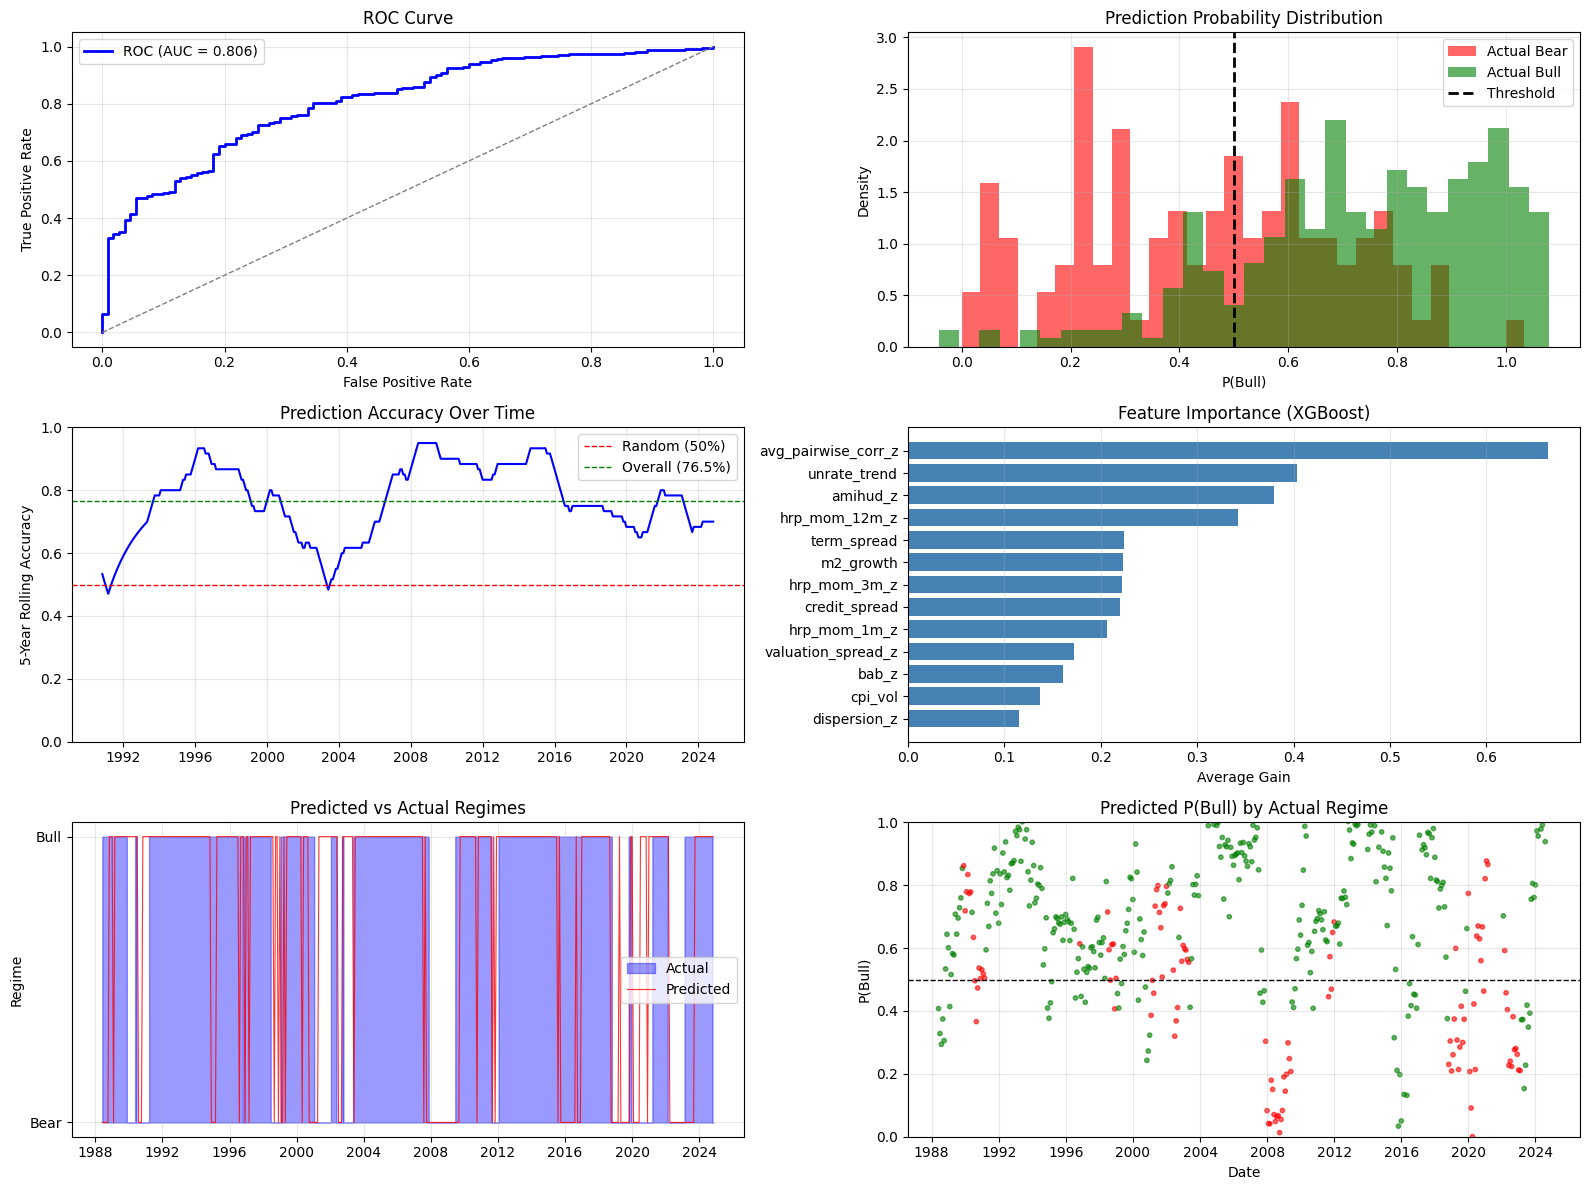


XGBOOST PREDICTION COVERAGE
  Start: 1988-05-31
  End:   2024-10-31
  Total: 438 months (36 years)

  ✓ No gaps: continuous monthly coverage
  ✓ No missing values in predictions

Confusion Matrix:
                    Predicted Bear  Predicted Bull
Actual Bear                   60                50
Actual Bull                   53               275

Top 5 Features (Avg Gain):
  avg_pairwise_corr_z: 0.66
  unrate_trend: 0.40
  amihud_z: 0.38
  hrp_mom_12m_z: 0.34
  term_spread: 0.22


In [13]:
# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 3 (Continued): XGBoost VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════════

print("="*70)
print("PHASE 3: XGBoost ANALYSIS VISUALIZATION")
print("="*70)

fig = hrp_viz.plot_xgb_analysis(
    wf_df, 
    feature_importances=feature_importances,
    save_path=os.path.join(super_agent_dir, 'phase3_xgb_analysis.png')
)
plt.show()

# Print confusion matrix, top features, and prediction coverage
hrp_ml.print_xgb_summary(metrics, feature_importances, top_n=5, wf_df=wf_df)

In [14]:
# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 4: HRP INTEGRATION (Execution Logic) - GROSS RETURNS
# ═══════════════════════════════════════════════════════════════════════════════

print("="*70)
print("PHASE 4: HRP INTEGRATION (GROSS RETURNS)")
print("="*70)
print("Two-Fund Separation: w × HRP + (1-w) × T-Bill")
print("Asymmetric Financing: Earn r_f when L<1, Pay r_f+spread when L>1")
print("NOTE: Transaction costs applied in Phase 5")

# Configuration from config.yaml
BEAR_ALLOCATION = strategy_config.get('bear_allocation', 0.5)
FINANCING_SPREAD_BPS = strategy_config.get('financing_spread_bps', 50)
print(f"\nConfig: bear_allocation={BEAR_ALLOCATION}, financing_spread={FINANCING_SPREAD_BPS}bps")

# Compute GROSS strategy returns (includes financing cost, no tx costs yet)
# - stock_returns: enables drift-adjusted turnover calculation
# - financing_spread_bps: asymmetric borrowing cost when leveraged
strategy_results = hrp_strategy.compute_strategy_returns(
    strategy_returns, wf_df, hrp_weights,
    bear_allocation=BEAR_ALLOCATION,
    rf_rate=rf_monthly_aligned,
    stock_returns=returns_all,  # For drift-adjusted turnover
    financing_spread_bps=FINANCING_SPREAD_BPS  # Borrowing spread (IBKR Pro: 50bps)
)

print(f"Strategy results: {len(strategy_results)} months")

# Define strategies (GROSS returns)
strategies = {
    'Buy & Hold HRP': 'hrp_return',
    'P(Bull) Scaled': 'regime_prob_scaled_return'
}

# Performance with bootstrap CI (GROSS)
print("\n[GROSS RETURNS - Before Transaction Costs]")
performance_ci = hrp_ml.print_performance_with_ci(strategy_results, strategies, rf_monthly_aligned)

# Allocation statistics
scale_factor = strategy_results['prob_scale_factor'].iloc[0]
print(f"\nP(Bull) Scaled Allocation:")
print(f"  Scale Factor: {scale_factor:.3f}x (1 / mean P(Bull))")
print(f"  Mean Allocation: {strategy_results['allocation_prob_scaled'].mean():.1%}")
print(f"  Range: [{strategy_results['allocation_prob_scaled'].min():.1%}, {strategy_results['allocation_prob_scaled'].max():.1%}]")
print(f"  % Time Leveraged (w>1): {(strategy_results['allocation_prob_scaled'] > 1).mean():.1%}")

# Prediction quality
pred_quality = hrp_strategy.compute_prediction_quality(strategy_results)
print(f"\nBear Detection Rate: {pred_quality['bear_detection_rate']:.1%}")
print(f"False Bear Rate: {pred_quality['false_bear_rate']:.1%}")

print(f"\n✓ Phase 4 Complete (GROSS returns with financing cost)")

PHASE 4: HRP INTEGRATION (GROSS RETURNS)
Two-Fund Separation: w × HRP + (1-w) × T-Bill
Asymmetric Financing: Earn r_f when L<1, Pay r_f+spread when L>1
NOTE: Transaction costs applied in Phase 5

Config: bear_allocation=0.5, financing_spread=50bps
2026-01-07 21:38:32,187 - HRP_Agent - INFO - Computing drift-adjusted turnover (accounts for price drift during holding period)
2026-01-07 21:38:32,355 - HRP_Agent - INFO - Strategy GROSS returns computed for 438 months
2026-01-07 21:38:32,357 - HRP_Agent - INFO - Prob-Weighted scale factor: 1.503x (mean P(Bull)=0.665)
2026-01-07 21:38:32,358 - HRP_Agent - INFO - Mean Rf rate: 2.85% annualized (over strategy period)
2026-01-07 21:38:32,359 - HRP_Agent - INFO - Financing spread: 50 bps (applied in NET only)
2026-01-07 21:38:32,360 - HRP_Agent - INFO - Levered months: 239/438 (54.6%), avg leverage when levered: 1.30x
Strategy results: 438 months

[GROSS RETURNS - Before Transaction Costs]

PERFORMANCE COMPARISON (95% CI) - Excess Return Sharpe


PHASE 4: EQUITY CURVES (Linear + Log Scale)

PERFORMANCE SUMMARY (Annualized) - Excess Return Sharpe
Date Range: 1988-05 to 2024-10 (438 months)
Risk-Free Rate: Mean = 3.32% annualized

Strategy               Return      Vol   Sharpe        DD1        DD2        DD3        DD4        DD5
---------------------------------------------------------------------------------------------------------
Buy & Hold HRP         10.4%   13.0%     0.58     -46.8%     -31.7%     -20.7%     -18.1%     -14.5%
P(Bull) Scaled         13.8%   11.3%     0.91     -24.4%     -14.1%     -13.8%     -13.5%     -10.8%
CRSP VW Index          11.5%   15.6%     0.59     -39.6%     -31.4%     -26.3%     -17.8%     -16.6%
---------------------------------------------------------------------------------------------------------

TOP 5 DRAWDOWN PERIODS (by magnitude)

Buy & Hold HRP:
  1.  -46.8%  (2007-10 to 2009-01)
  2.  -31.7%  (2000-09 to 2002-08)
  3.  -20.7%  (2020-01 to 2020-02)
  4.  -18.1%  (2021-12 to 2022-08)


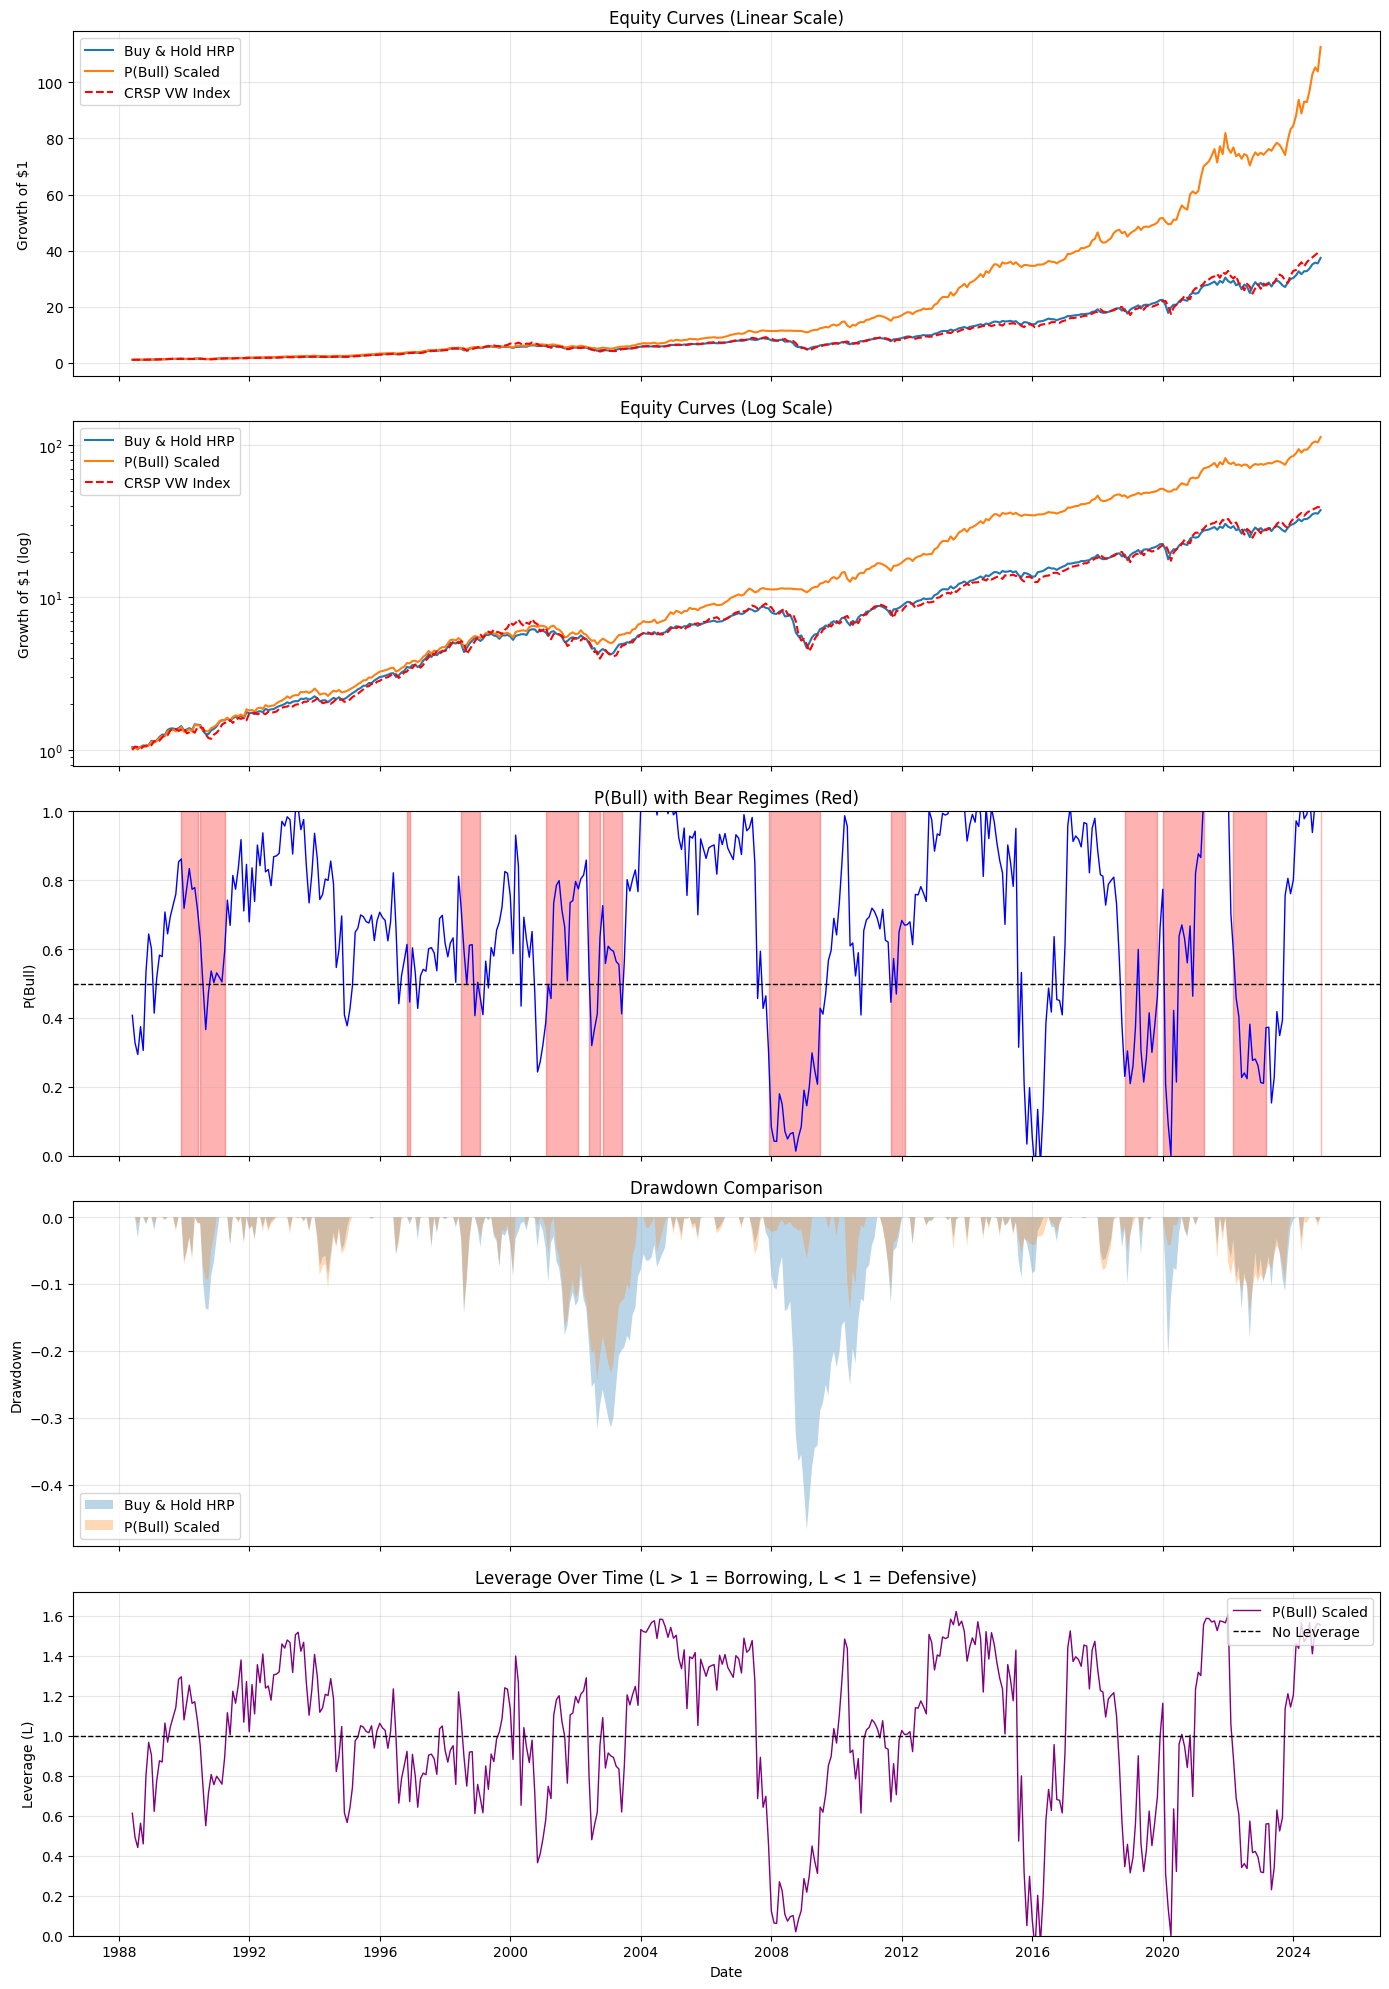

✓ Equity curves plotted (both linear and log scale)


In [15]:
# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 4 (Continued): EQUITY CURVES VISUALIZATION
# ═══════════════════════════════════════════════════════════════════════════════

print("="*70)
print("PHASE 4: EQUITY CURVES (Linear + Log Scale)")
print("="*70)

# Print performance summary with top 3 drawdowns (HRP, P(Bull) Scaled, CRSP VW)
metrics_summary = hrp_ml.print_performance_summary(
    strategy_results, strategies, market_returns, rf_monthly_aligned
)

# Plot equity curves
fig = hrp_viz.plot_strategy_equity_curves(
    strategy_results, 
    strategies,
    market_returns=market_returns,
    save_path=os.path.join(super_agent_dir, 'phase4_hrp_integration.png')
)
plt.show()

print("✓ Equity curves plotted (both linear and log scale)")

PHASE 5: TWO-STAGE TRANSACTION COST ANALYSIS

📊 TWO-STAGE HRP FRAMEWORK:
   Stage 1 (Inner): Within-industry VW rebalancing = 10 bps
   Stage 2 (Outer): HRP rebalancing across 12 industries = 10 bps
   Leverage Overlay: 2× allocation change + financing spread

✓ Industry ETF Returns: 775 months × 12 industries
✓ HRP Industry Weights: 709 months × 12 industries
✓ Within-Industry Weights: 775 rebalance dates loaded
2026-01-07 21:38:58,420 - HRP_Agent - INFO - Two-Stage Transaction Costs Computed:
2026-01-07 21:38:58,423 - HRP_Agent - INFO -   Inner cost (within-industry): mean 0.09% ann
2026-01-07 21:38:58,424 - HRP_Agent - INFO -   Outer cost (HRP rebalancing): mean 0.18% ann
2026-01-07 21:38:58,440 - HRP_Agent - INFO - Two-Stage Transaction Costs Applied:
2026-01-07 21:38:58,441 - HRP_Agent - INFO -   Stage 1 (Within-Industry): 10 bps -> 0.09% ann
2026-01-07 21:38:58,443 - HRP_Agent - INFO -   Stage 2 (HRP Rebalancing): 10 bps -> 0.18% ann
2026-01-07 21:38:58,444 - HRP_Agent - INFO -  

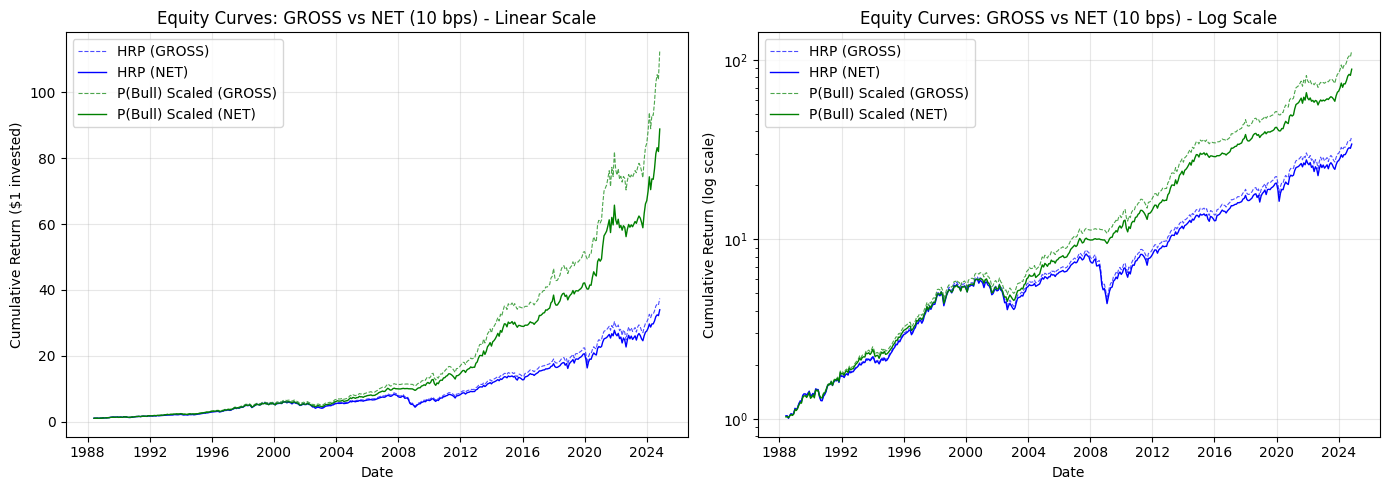


✓ Phase 5 Complete (Two-Stage Transaction Costs Applied)


In [16]:
# ═══════════════════════════════════════════════════════════════════════════════
# PHASE 5: TWO-STAGE TRANSACTION COST ANALYSIS
# ═══════════════════════════════════════════════════════════════════════════════

import joblib

print("="*70)
print("PHASE 5: TWO-STAGE TRANSACTION COST ANALYSIS")
print("="*70)

# Load tx_cost_bps from config (same for inner and outer)
TX_COST_BPS = strategy_config.get('tx_cost_bps', 10)
INNER_COST_BPS = TX_COST_BPS  # Within-industry VW rebalancing
OUTER_COST_BPS = TX_COST_BPS  # HRP rebalancing across industries

print(f"\n📊 TWO-STAGE HRP FRAMEWORK:")
print(f"   Stage 1 (Inner): Within-industry VW rebalancing = {INNER_COST_BPS} bps")
print(f"   Stage 2 (Outer): HRP rebalancing across 12 industries = {OUTER_COST_BPS} bps")
print(f"   Leverage Overlay: 2× allocation change + financing spread")

# ═══════════════════════════════════════════════════════════════════════════════
# LOAD REQUIRED DATA FOR TWO-STAGE MODEL
# ═══════════════════════════════════════════════════════════════════════════════

# 1. Industry ETF returns (computed in Step 2, loaded in Step 6)
industry_returns_path = os.path.join(super_agent_dir, 'industry_etf_returns.csv')
if os.path.exists(industry_returns_path):
    industry_returns = pd.read_csv(industry_returns_path, index_col=0, parse_dates=True)
    print(f"\n✓ Industry ETF Returns: {industry_returns.shape[0]} months × {industry_returns.shape[1]} industries")
else:
    raise FileNotFoundError(f"Industry ETF returns not found: {industry_returns_path}")

# 2. HRP industry weights (Ω_k,t) - from pipeline
industry_weights_path = os.path.join(super_agent_dir, 'hrp_industry_weights.csv')
if os.path.exists(industry_weights_path):
    hrp_industry_weights_df = pd.read_csv(industry_weights_path, index_col=0, parse_dates=True)
    print(f"✓ HRP Industry Weights: {hrp_industry_weights_df.shape[0]} months × {hrp_industry_weights_df.shape[1]} industries")
else:
    raise FileNotFoundError(f"HRP industry weights not found: {industry_weights_path}")

# 3. Within-industry weights (w_i,t for each industry k) - from pipeline
within_industry_weights_path = os.path.join(super_agent_dir, 'within_industry_weights.pkl')
if os.path.exists(within_industry_weights_path):
    within_industry_weights = joblib.load(within_industry_weights_path)
    print(f"✓ Within-Industry Weights: {len(within_industry_weights)} rebalance dates loaded")
else:
    raise FileNotFoundError(f"Within-industry weights not found: {within_industry_weights_path}")

# ═══════════════════════════════════════════════════════════════════════════════
# APPLY TWO-STAGE TRANSACTION COSTS
# ═══════════════════════════════════════════════════════════════════════════════

strategy_results_net = hrp_strategy.compute_net_returns_two_stage(
    strategy_results,
    industry_weights=hrp_industry_weights_df,
    within_industry_weights=within_industry_weights,
    industry_returns=industry_returns,
    stock_returns=returns_all,
    inner_cost_bps=INNER_COST_BPS,
    outer_cost_bps=OUTER_COST_BPS
)

# Print detailed two-stage cost breakdown
hrp_strategy.print_tx_cost_summary_two_stage(
    strategy_results_net, 
    inner_cost_bps=INNER_COST_BPS,
    outer_cost_bps=OUTER_COST_BPS
)

# Define NET strategies
strategies_net = {
    'Buy & Hold HRP': 'hrp_return_net',
    'P(Bull) Scaled': 'regime_prob_scaled_return_net'
}

# Performance with bootstrap CI (NET)
print("\n[NET RETURNS - After Two-Stage Transaction Costs]")
performance_ci_net = hrp_ml.print_performance_with_ci(strategy_results_net, strategies_net, rf_monthly_aligned)

# Compare GROSS vs NET performance
print("\n" + "="*70)
print("GROSS vs NET PERFORMANCE COMPARISON")
print("="*70)
print(f"\n{'Strategy':<20} {'Gross Sharpe':>14} {'Net Sharpe':>14} {'Sharpe Drag':>14}")
print("-"*65)

gross_sharpe_hrp = performance_ci['Buy & Hold HRP']['Sharpe']
net_sharpe_hrp = performance_ci_net['Buy & Hold HRP']['Sharpe']
print(f"{'Buy & Hold HRP':<20} {gross_sharpe_hrp:>14.2f} {net_sharpe_hrp:>14.2f} {gross_sharpe_hrp - net_sharpe_hrp:>14.2f}")

gross_sharpe_scaled = performance_ci['P(Bull) Scaled']['Sharpe']
net_sharpe_scaled = performance_ci_net['P(Bull) Scaled']['Sharpe']
print(f"{'P(Bull) Scaled':<20} {gross_sharpe_scaled:>14.2f} {net_sharpe_scaled:>14.2f} {gross_sharpe_scaled - net_sharpe_scaled:>14.2f}")

# ═══════════════════════════════════════════════════════════════════════════════
# EQUITY CURVES: GROSS vs NET (Linear + Log Scale)
# ═══════════════════════════════════════════════════════════════════════════════
print("\n" + "="*70)
print("EQUITY CURVES: GROSS vs NET (Two-Stage TX Costs)")
print("="*70)

fig = hrp_viz.plot_gross_vs_net_equity(
    strategy_results, strategy_results_net, 
    tx_cost_bps=TX_COST_BPS,
    save_path=os.path.join(super_agent_dir, 'phase5_gross_vs_net_equity.png')
)
plt.show()

print(f"\n✓ Phase 5 Complete (Two-Stage Transaction Costs Applied)")

SUB-SAMPLE PERFORMANCE ANALYSIS (Sharpe Ratio)

SHARPE RATIOS BY SUB-SAMPLE:
                                    HRP (Gross)  Scaled (Gross)  HRP (Net)  \
Period                                                                       
Sub-Sample 1\n(1988-05 to 2000-06)         0.95            1.00       0.92   
Sub-Sample 2\n(2000-07 to 2012-08)         0.29            0.79       0.27   
Sub-Sample 3\n(2012-09 to 2024-10)         0.84            1.27       0.82   

                                    Scaled (Net)  
Period                                            
Sub-Sample 1\n(1988-05 to 2000-06)          0.95  
Sub-Sample 2\n(2000-07 to 2012-08)          0.74  
Sub-Sample 3\n(2012-09 to 2024-10)          1.20  

Stability (Std Dev of Sharpe across periods - Lower is better):
Scaled (Net)      0.23
Scaled (Gross)    0.24
HRP (Net)         0.35
HRP (Gross)       0.35
dtype: float64


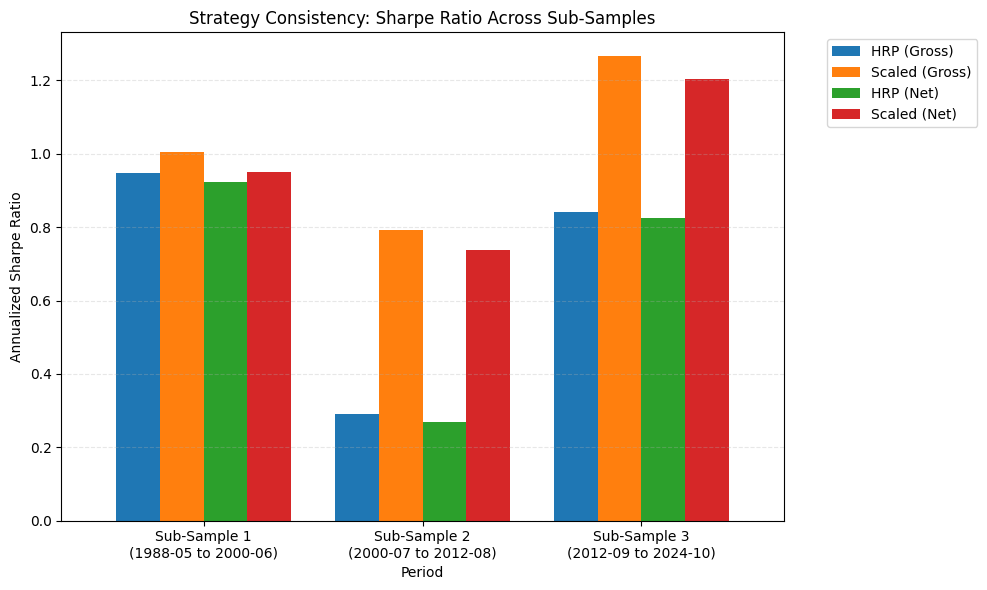


EQUITY CURVES BY SUB-SAMPLE (Log Scale)


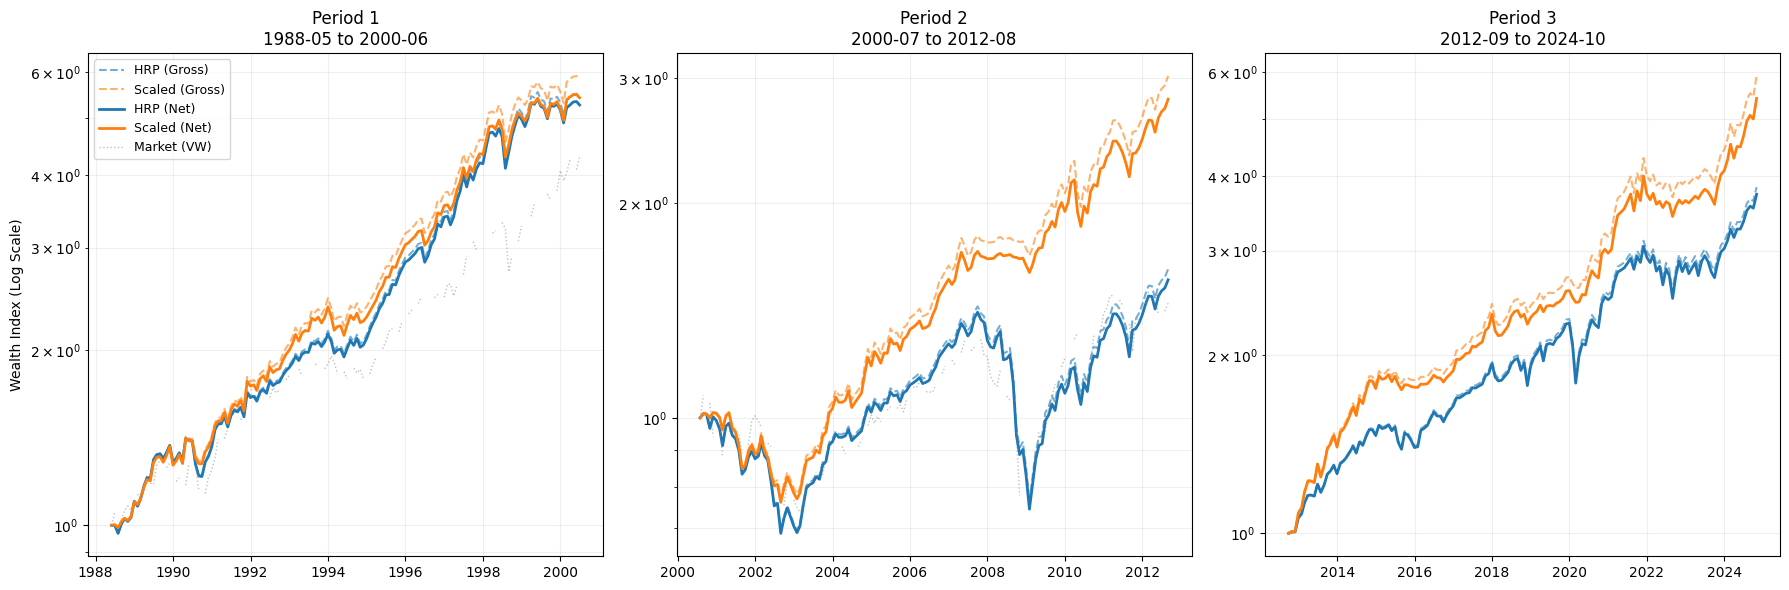

In [17]:
# ═══════════════════════════════════════════════════════════════════════════════
# SUB-SAMPLE ANALYSIS (3 PERIODS)
# ═══════════════════════════════════════════════════════════════════════════════
# Analyze consistency of Sharpe Ratio across three equal time periods

print("="*70)
print("SUB-SAMPLE PERFORMANCE ANALYSIS (Sharpe Ratio)")
print("="*70)

# 1. Compute Sub-Sample Performance
results_df, df_analysis, periods = hrp_analytics.analyze_subsample_performance(
    strategy_results, 
    strategy_results_net, 
    rf_monthly_aligned, 
    n_periods=3
)

# Print Table
print("\nSHARPE RATIOS BY SUB-SAMPLE:")
print(results_df.round(2))

# Stability Metric
print("\nStability (Std Dev of Sharpe across periods - Lower is better):")
print(results_df.std().sort_values().round(2))

# 2. Visualize Stability (Bar Chart)
hrp_viz.plot_subsample_sharpe(
    results_df, 
    save_path=os.path.join(super_agent_dir, 'subsample_sharpe_stability.png')
)

# 3. Visualize Equity Curves by Sub-Sample
print("\n" + "="*70)
print("EQUITY CURVES BY SUB-SAMPLE (Log Scale)")
print("="*70)

hrp_viz.plot_subsample_equity_curves(
    df_analysis, 
    periods, 
    market_returns=market_returns,
    save_path=os.path.join(super_agent_dir, 'subsample_equity_curves.png')
)


In [19]:
# ═══════════════════════════════════════════════════════════════════════════════
# STATISTICAL SIGNIFICANCE TEST (Paired Block Bootstrap)
# ═══════════════════════════════════════════════════════════════════════════════
# Test if the difference in Sharpe Ratios is statistically significant
# Hypo: SR(Strategy) > SR(Benchmark) (One-sided)

print("="*70)
print("STATISTICAL SIGNIFICANCE TEST (Bootstrap Sharpe Ratio)")
print("="*70)
print("Method: Paired Block Bootstrap (Preserves serial correlation)")
print("Params: n_bootstrap=10000, block_size=12 (1 year)")

# Align indices
# FIX: Ensure market_returns is aligned to month-end (ME) like strategy_results_net
# Use month period matching to robustly handle trading day vs calendar day mismatches
def robust_align_to_target(source_series, target_index):
    # Convert both to period 'M' to match month-for-month
    s_idx = pd.to_datetime(source_series.index).to_period('M')
    t_idx = pd.to_datetime(target_index).to_period('M')
    
    # Check if source has duplicates (daily data)
    if len(source_series) > len(s_idx.unique()):
        # Daily or duplicates -> compound to monthly
        # print(f"  Aggregating {source_series.name or 'series'} from daily/mixed to monthly...")
        compound = lambda x: (1 + x).prod() - 1
        s_monthly = source_series.groupby(s_idx).apply(compound)
    else:
        # Already unique months -> just look up by period
        s_monthly = source_series.copy()
        s_monthly.index = s_idx

    # Reindex to target months
    aligned_values = s_monthly.reindex(t_idx)
    
    # Return as series with target index
    aligned_series = pd.Series(aligned_values.values, index=target_index, name=source_series.name)
    return aligned_series

market_returns_aligned = robust_align_to_target(market_returns, strategy_results_net.index)
rf_aligned = robust_align_to_target(rf_monthly_aligned, strategy_results_net.index)

# Check for NaNs
if market_returns_aligned.isna().any():
    n_nans = market_returns_aligned.isna().sum()
    print(f"Warning: Dropping {n_nans} NaN months from market/risk-free alignment")
    valid_mask = ~market_returns_aligned.isna() & ~rf_aligned.isna()
    market_returns_aligned = market_returns_aligned[valid_mask]
    rf_aligned = rf_aligned[valid_mask]
    # Also filter the strategy results to match valid market data
    strategy_results_net_subset = strategy_results_net.loc[market_returns_aligned.index]
else:
    strategy_results_net_subset = strategy_results_net

# Compute Excess Returns for Sharpe Calculation
# (The bootstrap function calculates SR = mean/std, so inputs must be Excess Returns)
hrp_excess = strategy_results_net_subset['hrp_return_net'] - rf_aligned
scaled_excess = strategy_results_net_subset['regime_prob_scaled_return_net'] - rf_aligned
mkt_excess = market_returns_aligned - rf_aligned

# 1. TEST: HRP (Net) vs Market (CRSP VW)
print("\n[Test 1] Buy & Hold HRP (Net) vs Market (CRSP VW)")
diff_mean, diff_ci, sig = hrp_ml.bootstrap_sharpe_test(
    mkt_excess.values,      # Baseline
    hrp_excess.values,      # Strategy
    n_bootstrap=10000, 
    block_size=12
)
print(f"  Sharpe Difference (Mean): {diff_mean:.4f}")
print(f"  95% CI: [{diff_ci[0]:.4f}, {diff_ci[1]:.4f}]")
print(f"  Result: {sig}")

# 2. TEST: P(Bull) Scaled (Net) vs Buy & Hold HRP (Net)
print("\n[Test 2] P(Bull) Scaled (Net) vs Buy & Hold HRP (Net)")
diff_mean, diff_ci, sig = hrp_ml.bootstrap_sharpe_test(
    hrp_excess.values,      # Baseline
    scaled_excess.values,   # Strategy
    n_bootstrap=10000, 
    block_size=12
)
print(f"  Sharpe Difference (Mean): {diff_mean:.4f}")
print(f"  95% CI: [{diff_ci[0]:.4f}, {diff_ci[1]:.4f}]")
print(f"  Result: {sig}")

# 3. TEST: P(Bull) Scaled (Net) vs Market (CRSP VW)
print("\n[Test 3] P(Bull) Scaled (Net) vs Market (CRSP VW)")
diff_mean, diff_ci, sig = hrp_ml.bootstrap_sharpe_test(
    mkt_excess.values,      # Baseline
    scaled_excess.values,   # Strategy
    n_bootstrap=10000, 
    block_size=12
)
print(f"  Sharpe Difference (Mean): {diff_mean:.4f}")
print(f"  95% CI: [{diff_ci[0]:.4f}, {diff_ci[1]:.4f}]")
print(f"  Result: {sig}")

STATISTICAL SIGNIFICANCE TEST (Bootstrap Sharpe Ratio)
Method: Paired Block Bootstrap (Preserves serial correlation)
Params: n_bootstrap=10000, block_size=12 (1 year)

[Test 1] Buy & Hold HRP (Net) vs Market (CRSP VW)
  Sharpe Difference (Mean): 0.0362
  95% CI: [-0.1415, 0.2157]
  Result: Not significant

[Test 2] P(Bull) Scaled (Net) vs Buy & Hold HRP (Net)
  Sharpe Difference (Mean): 0.2993
  95% CI: [0.1040, 0.5454]
  Result: Significantly BETTER

[Test 3] P(Bull) Scaled (Net) vs Market (CRSP VW)
  Sharpe Difference (Mean): 0.3355
  95% CI: [0.0794, 0.6188]
  Result: Significantly BETTER


In [20]:
# ═══════════════════════════════════════════════════════════════════════════════
# FINAL OUTPUT: SAVE ALL RESULTS
# ═══════════════════════════════════════════════════════════════════════════════
import json

print("="*70)
print("FINAL OUTPUT: SAVING RESULTS")
print("="*70)

# Save strategy results (NET - after two-stage transaction costs)
strategy_results_net.to_csv(os.path.join(super_agent_dir, 'regime_strategy_results.csv'))
print("✓ Strategy results (NET - two-stage tx costs) saved")

# Save HMM regimes
df_regimes.to_csv(os.path.join(super_agent_dir, 'hmm_regimes_v2.csv'))
print("✓ HMM regimes saved")

# Save performance summary (NET)
perf_df = pd.DataFrame([{
    'Strategy': name,
    'Ann Return': m['Ann Return'],
    'Ann Vol': m['Ann Vol'],
    'Sharpe': m['Sharpe'],
    'Max DD': m['Max DD'],
    'Win Rate': m['Win Rate']
} for name, m in performance_ci_net.items()])
perf_df.to_csv(os.path.join(super_agent_dir, 'regime_performance_summary.csv'), index=False)
print("✓ Performance summary (NET) saved")

# Save model configuration (with two-stage tx cost info)
model_config = {
    'hmm': {'n_components': 2, 'min_train': HMM_MIN_TRAIN, 'refit_freq': HMM_REFIT_FREQ},
    'features': FEATURE_COLS,
    'tx_costs': {
        'model': 'two-stage',
        'inner_cost_bps': INNER_COST_BPS,  # Within-industry VW rebalancing
        'outer_cost_bps': OUTER_COST_BPS,  # HRP rebalancing across industries
        'leverage_cost_bps': OUTER_COST_BPS,  # Leverage overlay (2× allocation change)
        'financing_spread_bps': FINANCING_SPREAD_BPS  # Borrowing spread when L > 1
    },
    'prediction_metrics': {k: float(v) if isinstance(v, (np.floating, float)) else v 
                          for k, v in metrics.items() if k != 'confusion_matrix'},
    'date_range': {'start': str(strategy_results_net.index.min().date()), 
                   'end': str(strategy_results_net.index.max().date())}
}

with open(os.path.join(super_agent_dir, 'regime_model_config.json'), 'w') as f:
    json.dump(model_config, f, indent=2, default=str)
print("✓ Model configuration saved")

# Final summary
print("\n" + "="*70)
print("PIPELINE COMPLETE")
print("="*70)
print(f"""
Summary:
  Phase 1: HMM data prepared ({len(df_hmm)} observations)
  Phase 2: {len(df_regimes)} months labeled (Bear/Bull)
  Phase 3: {len(wf_df)} out-of-sample predictions (Acc={metrics['accuracy']:.1%}, AUC={metrics['roc_auc']:.3f})
  Phase 4: {len(strategies)} strategy variants (GROSS returns)
  Phase 5: Two-Stage Transaction Costs Applied
           - Stage 1 (Inner): Within-industry VW rebalancing ({INNER_COST_BPS} bps)
           - Stage 2 (Outer): HRP rebalancing across 12 industries ({OUTER_COST_BPS} bps)
           - Leverage Overlay: 2× |ΔL| + financing spread ({FINANCING_SPREAD_BPS} bps)

Best Strategy (NET): {perf_df.loc[perf_df['Sharpe'].idxmax(), 'Strategy']} (Sharpe = {perf_df['Sharpe'].max():.2f})
""")

print(perf_df.to_string(index=False))

FINAL OUTPUT: SAVING RESULTS
✓ Strategy results (NET - two-stage tx costs) saved
✓ HMM regimes saved
✓ Performance summary (NET) saved
✓ Model configuration saved

PIPELINE COMPLETE

Summary:
  Phase 1: HMM data prepared (679 observations)
  Phase 2: 559 months labeled (Bear/Bull)
  Phase 3: 438 out-of-sample predictions (Acc=76.5%, AUC=0.806)
  Phase 4: 2 strategy variants (GROSS returns)
  Phase 5: Two-Stage Transaction Costs Applied
           - Stage 1 (Inner): Within-industry VW rebalancing (10 bps)
           - Stage 2 (Outer): HRP rebalancing across 12 industries (10 bps)
           - Leverage Overlay: 2× |ΔL| + financing spread (50 bps)

Best Strategy (NET): P(Bull) Scaled (Sharpe = 0.85)

      Strategy  Ann Return  Ann Vol   Sharpe    Max DD  Win Rate
Buy & Hold HRP    0.101415 0.130121 0.555373 -0.470750  0.652968
P(Bull) Scaled    0.130811 0.113119 0.854485 -0.252323  0.650685
